In [1]:
import zipfile

import pandas as pd
import numpy as np

from IPython.display import Image, display  #To display images in a notebook
import matplotlib.pyplot as plt
import seaborn as sns

#Data preprocessing
from sklearn.experimental import enable_iterative_imputer   #Required to enable IterativeImputer
from sklearn.impute import IterativeImputer     #to HANDLE missing values
from sklearn.preprocessing import StandardScaler #To standardise variables
from sklearn.preprocessing import LabelEncoder #TO cencode categorical variables

#Splitting Training and test sets
from sklearn.multioutput import MultiOutputRegressor #for mulit output REgression
from sklearn.ensemble import RandomForestRegressor #RandomForest regression model
from xgboost import XGBRegressor    #XGBoost based regression model
from sklearn.feature_selection import SelectFromModel #TO select the most relevant features

#Model performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from datetime import datetime
import joblib   #To save and load training models
import os

In [2]:
!kaggle datasets download -d excel4soccer/espn-soccer-data


Dataset URL: https://www.kaggle.com/datasets/excel4soccer/espn-soccer-data
License(s): MIT
... resuming from 176163050 bytes (493820 bytes left) ...




100%|█████████▉| 168M/168M [00:00<?, ?B/s]
100%|█████████▉| 168M/168M [00:00<00:02, 165kB/s]


In [2]:
import zipfile

zip_path = "espn-soccer-data.zip"
extract_path = "espn_data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")


Extraction completed.


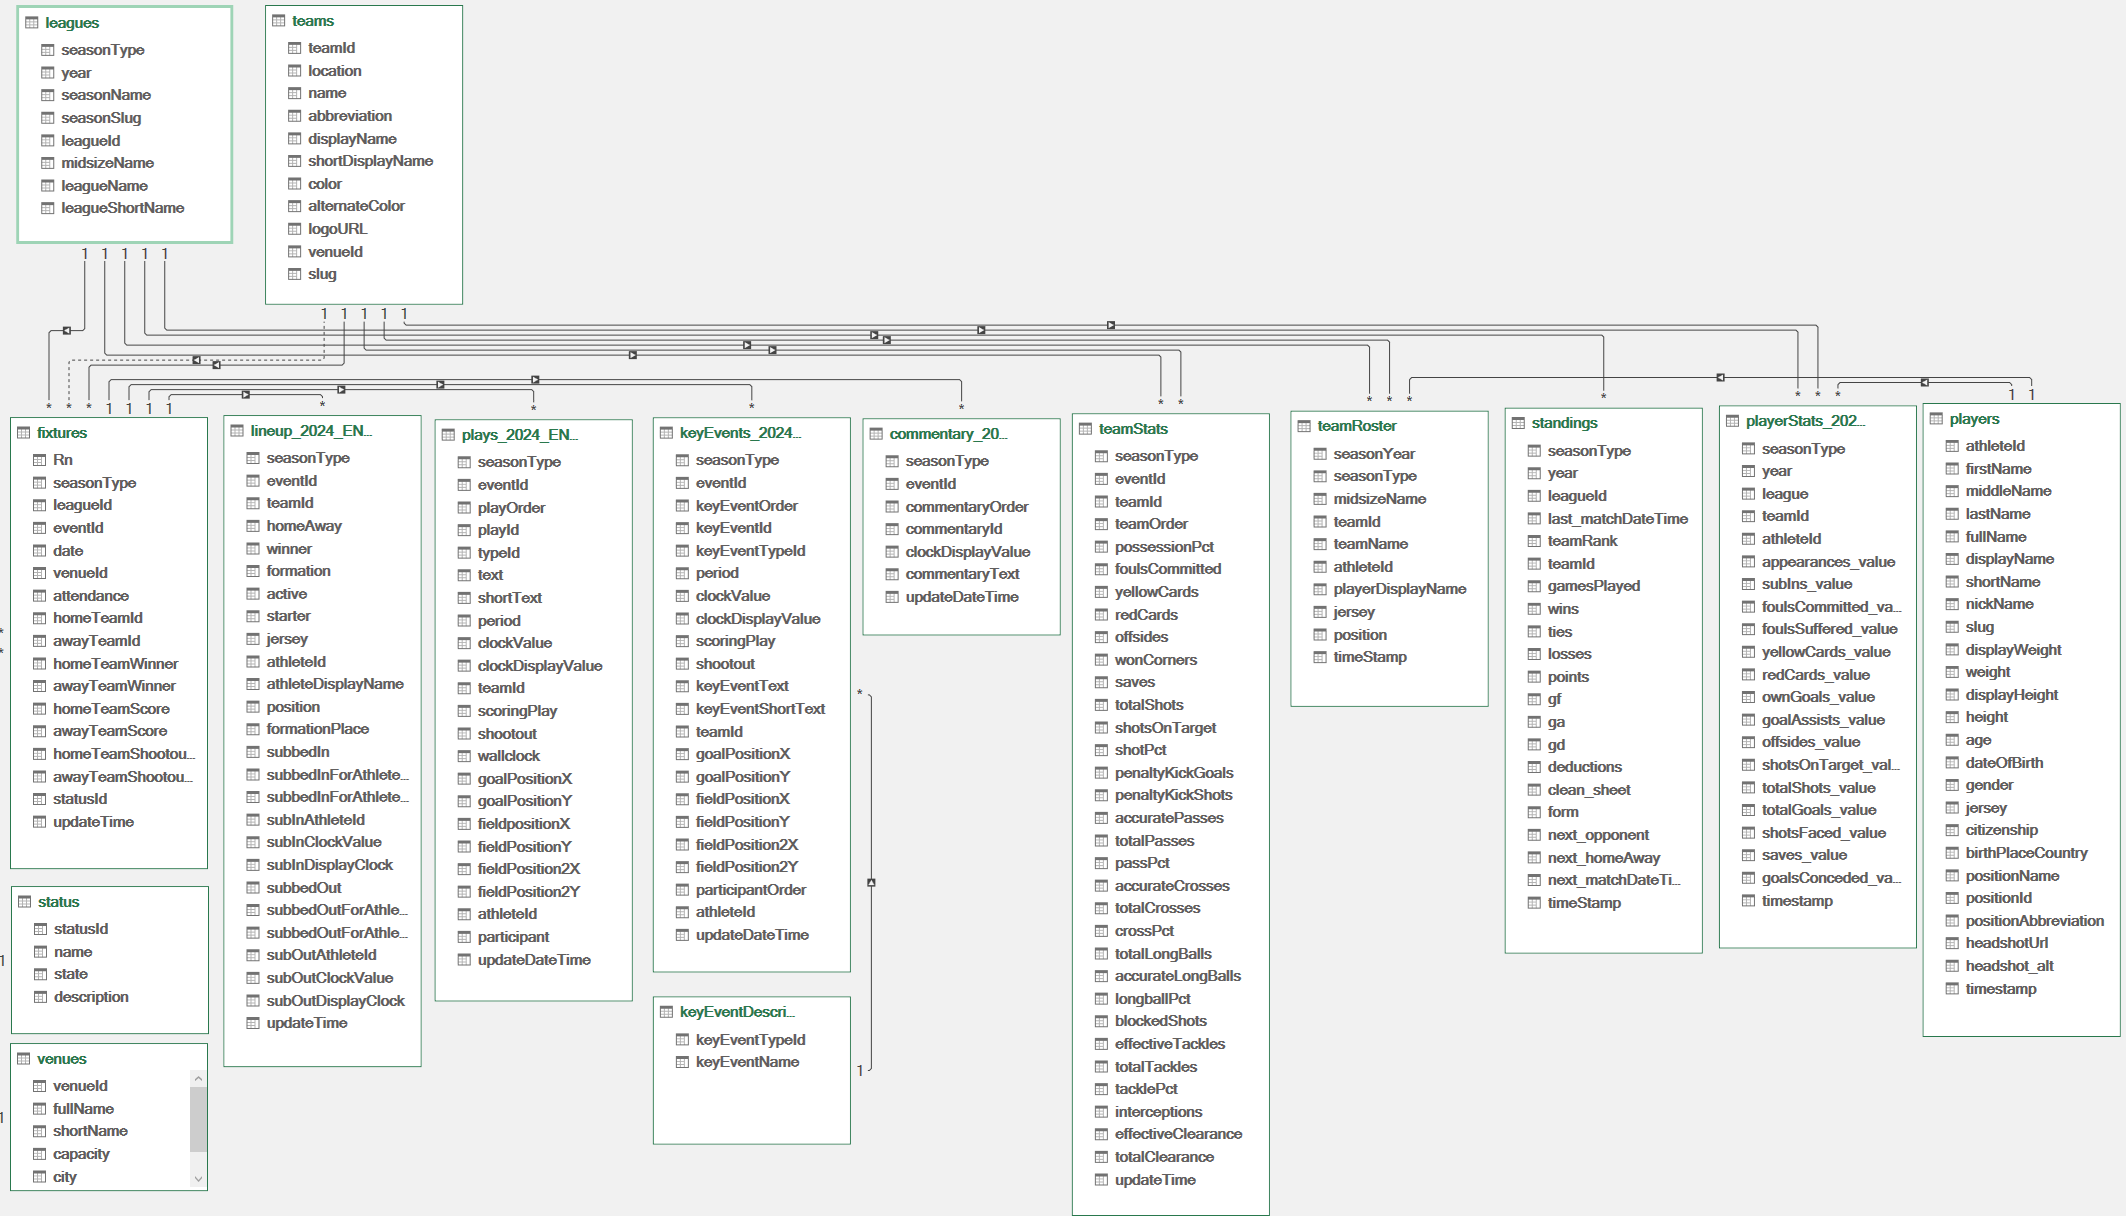

In [5]:
image_path="espn_data/base_data/dB_diagram.png"
display(Image(filename=image_path))

In [3]:
fixtures=pd.read_csv("espn_data/base_data/fixtures.csv")
print(" Preview of Fixtures ")
print(fixtures.head())

 Preview of Fixtures 
   Rn  seasonType  leagueId  eventId                 date  venueId  \
0   1       12136      3922   689519  2024-01-01 05:00:00     8680   
1   2       12136      3922   694555  2024-01-01 13:30:00     4775   
2   3       12136      3922   693431  2024-01-02 13:00:00     7614   
3   4       12136      3922   694586  2024-01-04 12:00:00     9877   
4   5       12136      3922   690701  2024-01-04 13:30:00     9876   

   attendance  homeTeamId  awayTeamId  homeTeamWinner  awayTeamWinner  \
0       61916         627        4396            True           False   
1           0         658        1928           False            True   
2           0        4895        2621           False            True   
3           0        1928        6723           False            True   
4           0         655        4388            True           False   

   homeTeamScore  awayTeamScore  homeTeamShootoutScore  awayTeamShootoutScore  \
0              5              0      

In [4]:
teamStats=pd.read_csv("espn_data/base_data/teamStats.csv")
print(teamStats.head())

   seasonType  eventId  teamId  teamOrder  possessionPct  foulsCommitted  \
0       12136   688265    4381          0           41.5             6.0   
1       12136   688265     628          1           58.5            19.0   
2       12136   689519     627          0           58.9             7.0   
3       12136   689519    4396          1           41.1             6.0   
4       12136   689956     448          0           52.9            11.0   

   yellowCards  redCards  offsides  wonCorners  ...  accurateLongBalls  \
0          1.0       0.0       1.0         1.0  ...               24.0   
1          1.0       0.0       3.0         3.0  ...               26.0   
2          0.0       0.0       1.0        13.0  ...               27.0   
3          2.0       0.0       1.0         3.0  ...               19.0   
4          1.0       0.0       2.0         7.0  ...               20.0   

   longballPct  blockedShots  effectiveTackles  totalTackles  tacklePct  \
0          0.4         

In [5]:
standings=pd.read_csv("espn_data/base_data/standings.csv")
print(standings.head())

   seasonType  year  leagueId   last_matchDateTime  teamRank  teamId  \
0       12215  2024     19915  2024-10-26 21:00:00         1   20684   
1       12215  2024     19915  2024-10-27 00:00:00         2   21354   
2       12215  2024     19915  2024-10-27 00:00:00         3   19995   
3       12215  2024     19915  2024-10-26 23:00:00         4   19964   
4       12215  2024     19915  2024-10-27 00:00:00         5   21821   

   gamesPlayed  wins  ties  losses  ...    gf    ga  gd  deductions  \
0           22    15     3       4  ...  47.0  24.0  23           0   
1           22    12     5       5  ...  34.0  18.0  16           0   
2           22    10     9       3  ...  35.0  18.0  17           0   
3           22    11     4       7  ...  39.0  28.0  11           0   
4           22     9     8       5  ...  23.0  16.0   7           0   

   clean_sheet   form next_opponent  next_homeAway next_matchDateTime  \
0          7.0  WDWWW           NaN            NaN                N

In [6]:
leagues=pd.read_csv("espn_data/base_data/leagues.csv")
print(leagues.head())

   seasonType  year                                         seasonName  \
0       12868  2024   2024-25 AFC Champions League Elite, League Stage   
1       12864  2024          2024-25 AFC Champions League Elite, Final   
2       12865  2024     2024-25 AFC Champions League Elite, Semifinals   
3       12866  2024  2024-25 AFC Champions League Elite, Quarterfinals   
4       12867  2024    2024-25 AFC Champions League Elite, Round of 16   

      seasonSlug  leagueId    midsizeName                  leagueName  \
0   league-stage      3902  AFC.CHAMPIONS  AFC Champions League Elite   
1          final      3902  AFC.CHAMPIONS  AFC Champions League Elite   
2     semifinals      3902  AFC.CHAMPIONS  AFC Champions League Elite   
3  quarterfinals      3902  AFC.CHAMPIONS  AFC Champions League Elite   
4    round-of-16      3902  AFC.CHAMPIONS  AFC Champions League Elite   

              leagueShortName  
0  AFC Champions League Elite  
1  AFC Champions League Elite  
2  AFC Champions Lea

In [7]:
#EXPLORATORY ANALYSIS

def explore_distributions(df, df_name):
    #Select numeric columns
    numeric_cols=df.select_dtypes(include=['number']).columns.tolist() #Extracts all column names in the DataFrame that contain numeric data types (integers or floats) and stores them in a list.  
    if not numeric_cols:        #Checks if the list of numeric columns is empty. If there are no numeric columns, it skips the analysis. 
        print(f"No numeric collumns in {df_name}")
        return
    
    print(f"\n=== Descriptive Statistics for {df_name}")
    print(df[numeric_cols].describe())      #Provides summary stats

    #Iterate over each Numeric collum to display plots
    for col in numeric_cols:
        fig,axs= plt.subplots(1,2,figsize=(14,4)) #subplots allow plotting of multiple charts in one | 
        #plt.subplots and plt.subplot is diff | plt.subplot plots one-by-one and subplots does it all at once

        #Histogram with density estimation
        sns.histplot(df[col].dropna(),kde=True, ax=axs[0],color='skyblue') #dropna stands for drop Not a Number and it removes any missing or empty values
        axs[0].set_title(f"Histogram of {col} ({df_name})")
        axs[0].set_xlabel(col)
        axs[0].set_ylabel("Frequency")

        #Box Plot
        sns.boxplot(x=df[col].dropna(),ax=axs[1],color='lightgreen')
        axs[1].set_title(f"Boxplot of {col} ({df_name})")
        axs[1].set_xlabel(col)

        plt.tight_layout    #Adjusts subplot layout so that plots don't overlap or appear too tight.
        plt.show()
        



### Distribution Analysis for fixtures ###

=== Descriptive Statistics for fixtures
                 Rn    seasonType      leagueId        eventId       venueId  \
count  67262.000000  67262.000000  67262.000000   67262.000000  67262.000000   
mean     240.894487  13017.852190   6054.179537  727184.492670   4795.690880   
std      468.536179    440.824406   5682.950421   20098.889187   3139.315486   
min        1.000000  12136.000000    601.000000  688265.000000     -1.000000   
25%       39.000000  12673.000000   3903.000000  710223.250000   1963.000000   
50%      109.000000  13041.000000   3943.000000  727394.500000   5375.000000   
75%      229.000000  13446.000000   8207.000000  744555.750000   7054.000000   
max     3477.000000  13876.000000  23633.000000  762473.000000  10902.000000   

          attendance     homeTeamId     awayTeamId  homeTeamScore  \
count   67262.000000   67262.000000   67262.000000   67262.000000   
mean     6479.494856   11303.496536   11499.493399     

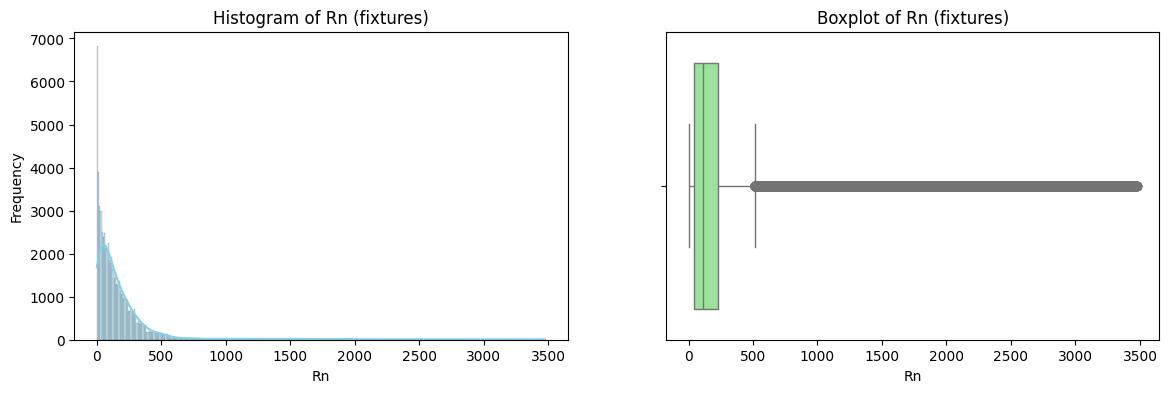

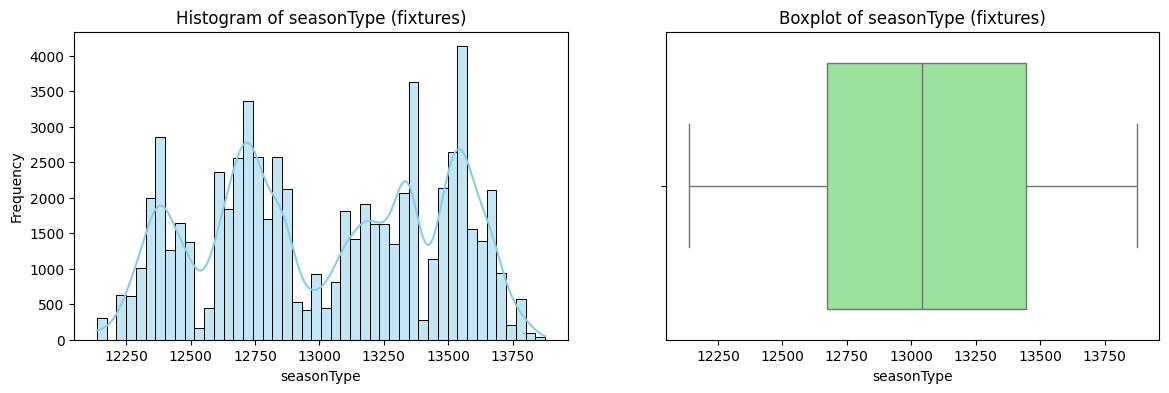

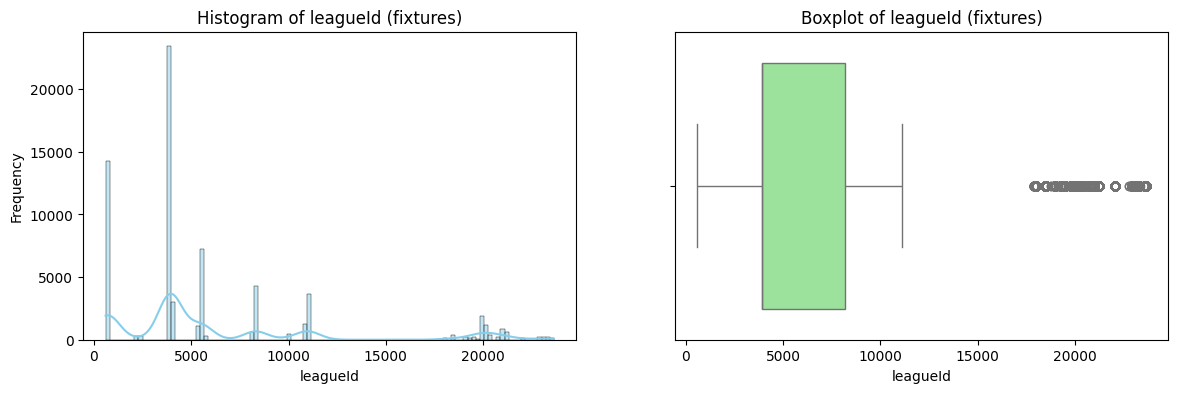

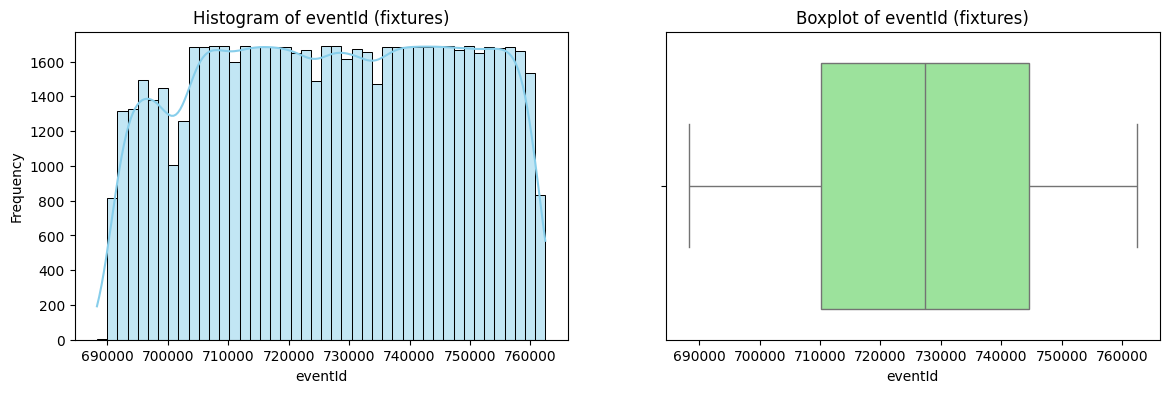

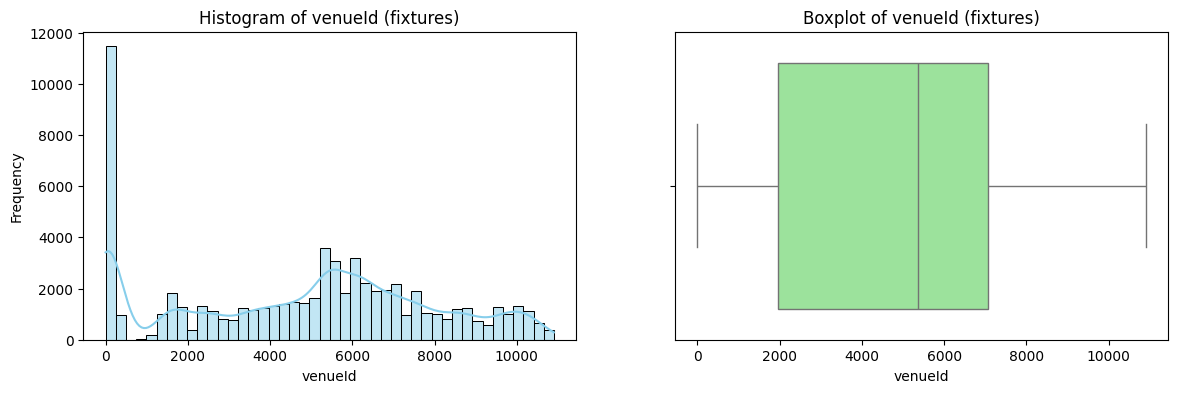

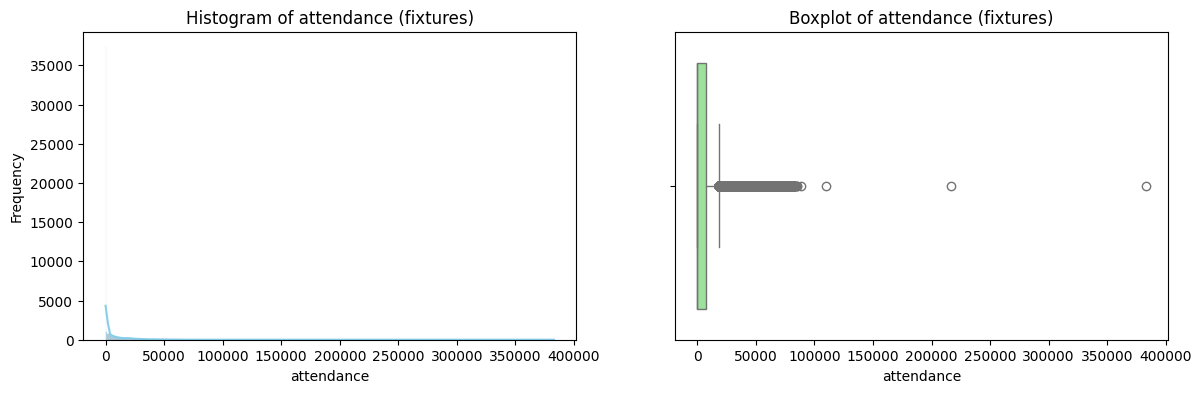

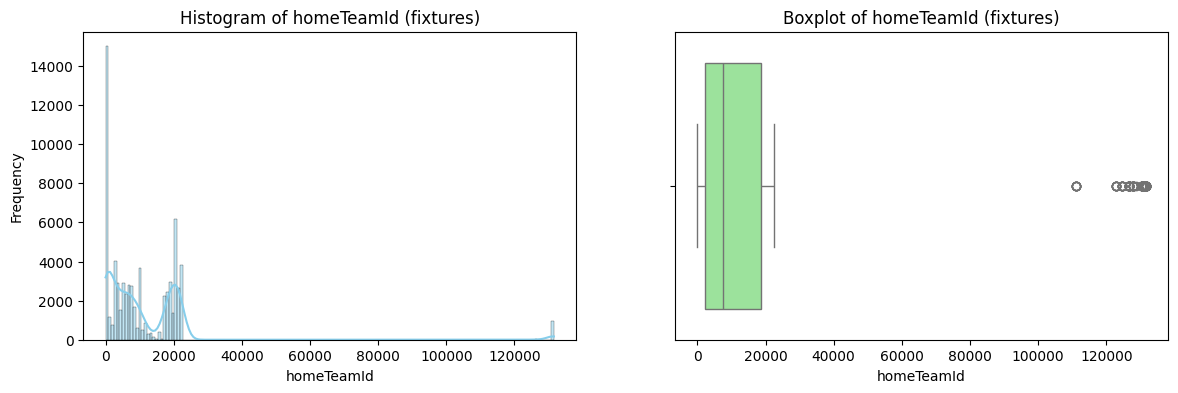

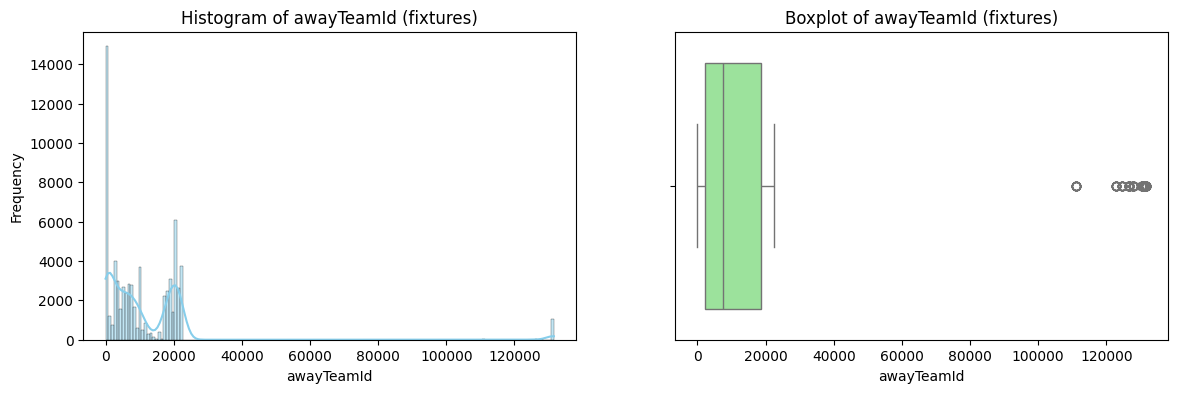

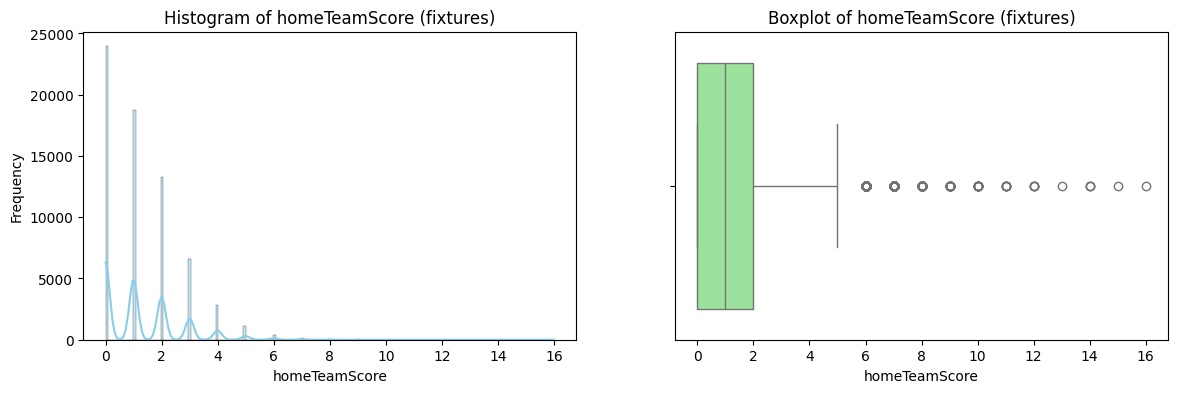

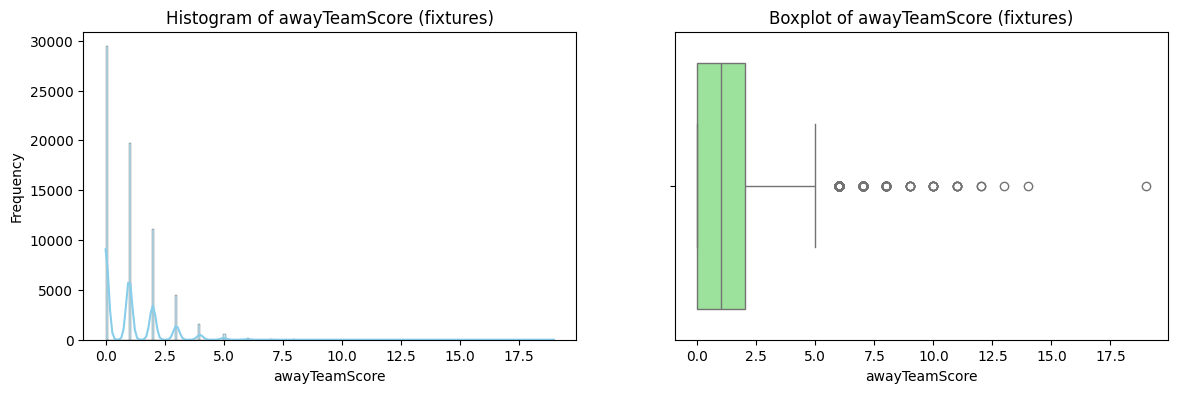

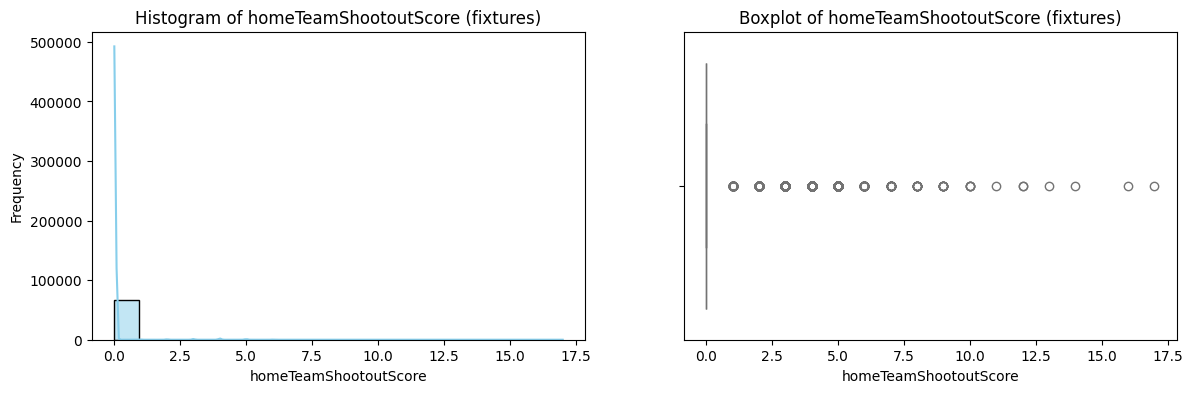

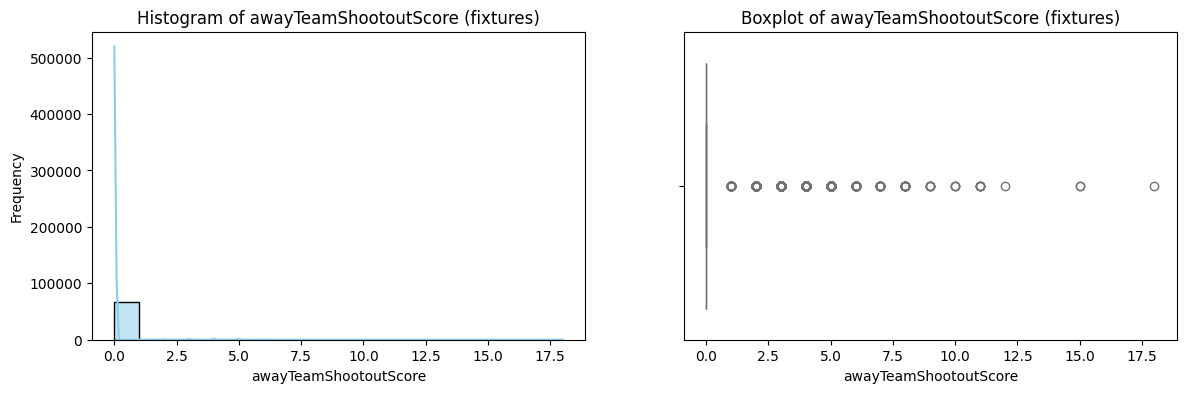

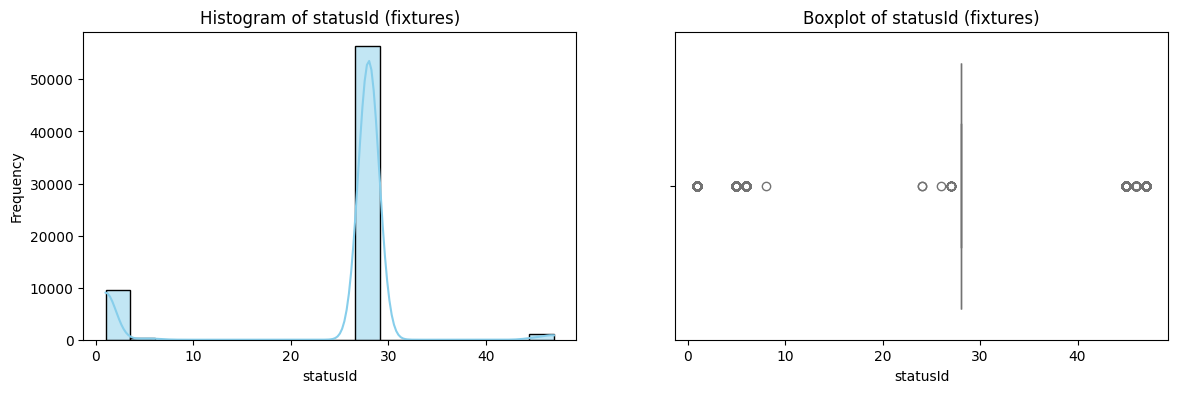

In [8]:
name="fixtures"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(fixtures, name)



### Distribution Analysis for teamStats ###

=== Descriptive Statistics for teamStats
          seasonType        eventId         teamId      teamOrder  \
count  102978.000000  102978.000000  102978.000000  102978.000000   
mean    12901.645740  721839.055895   10229.067917       0.500214   
std       413.434486   19089.765683   14649.784048       0.500002   
min     12136.000000  688265.000000       2.000000       0.000000   
25%     12622.000000  706395.250000    1538.000000       0.000000   
50%     12821.000000  720396.000000    7242.000000       1.000000   
75%     13208.000000  734499.750000   17805.000000       1.000000   
max     13876.000000  762438.000000  131553.000000       1.000000   

       possessionPct  foulsCommitted   yellowCards      redCards  \
count   56442.000000    56442.000000  56442.000000  56442.000000   
mean       49.901091       11.985879      2.009178      0.103310   
std        11.747645        4.101496      1.403848      0.327309   
min         0.0000

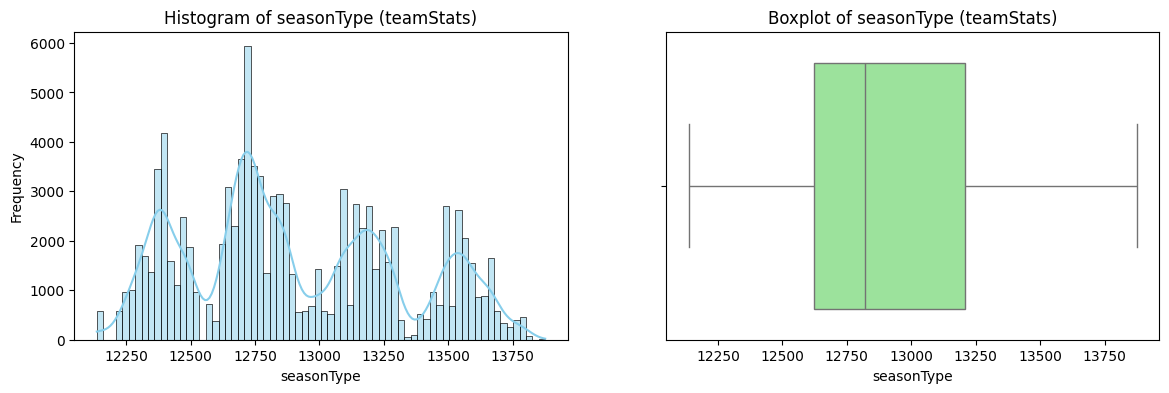

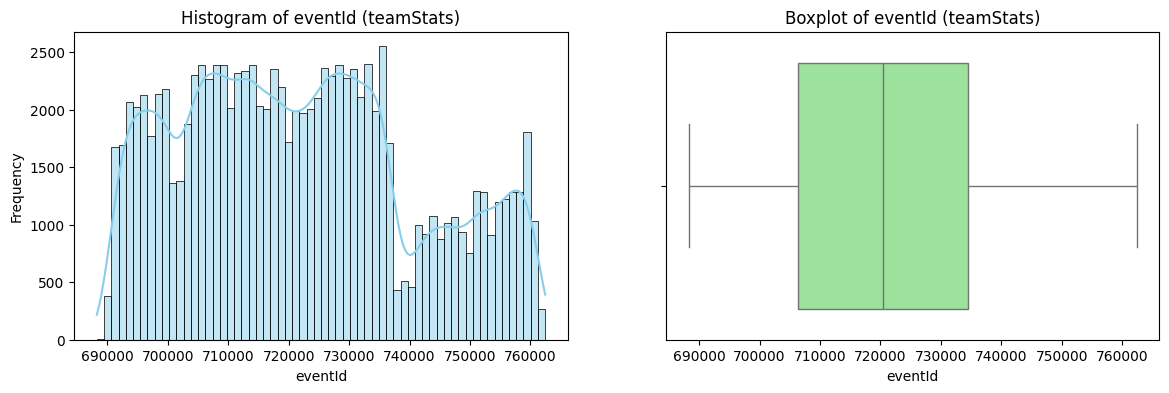

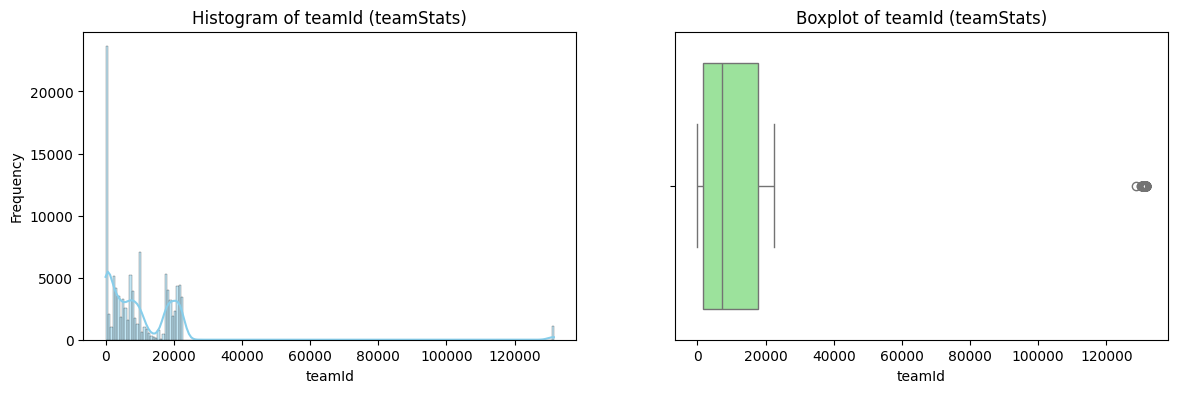

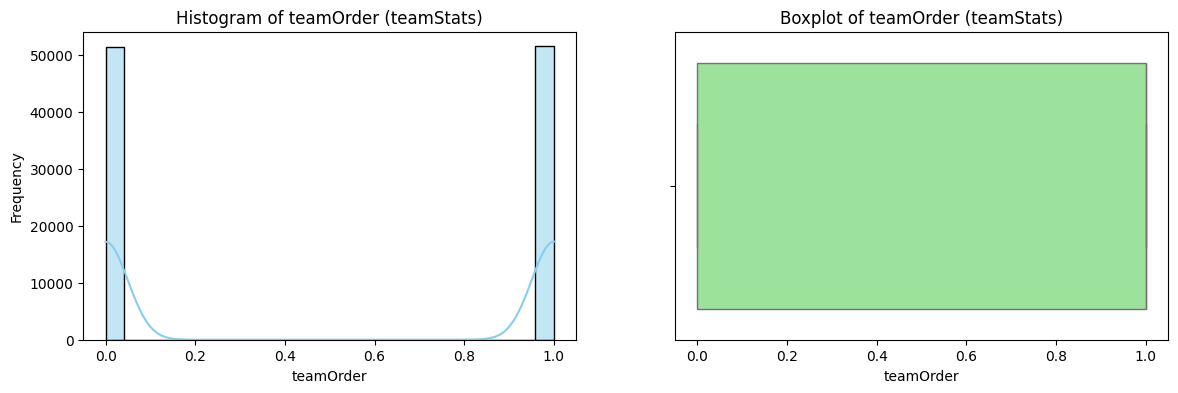

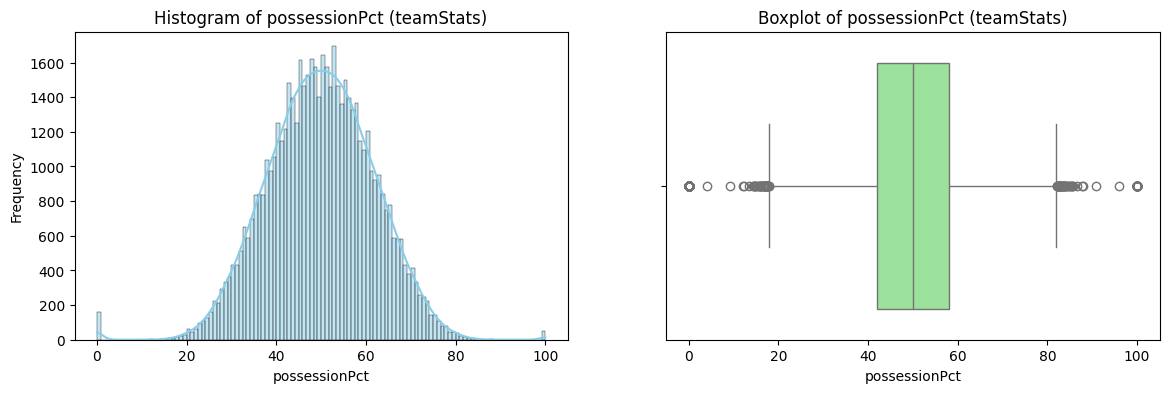

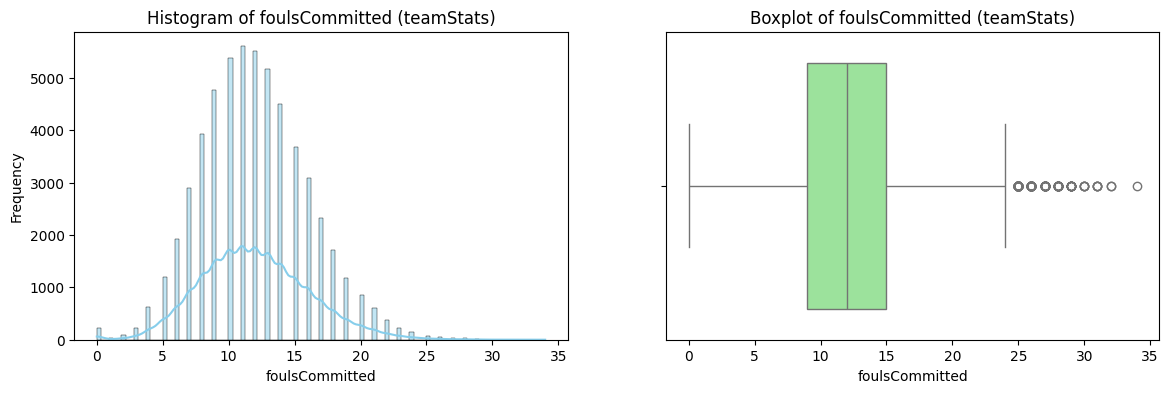

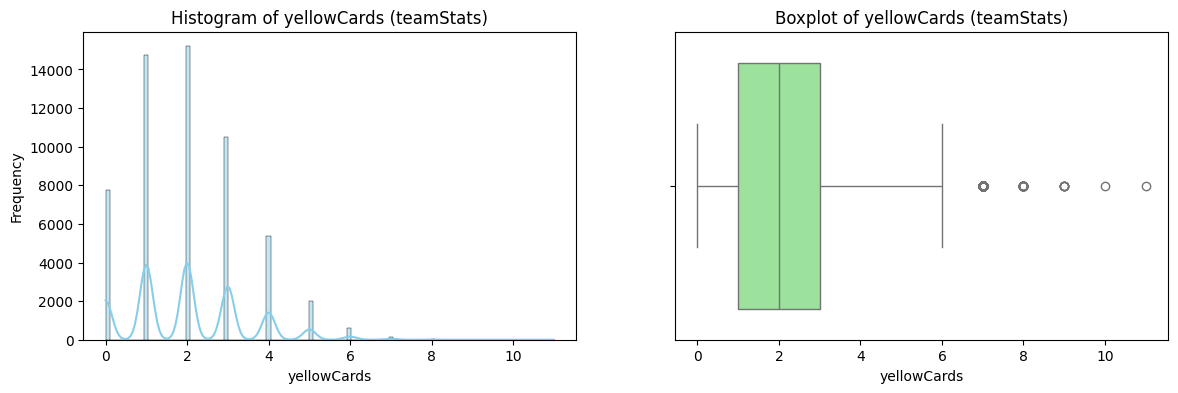

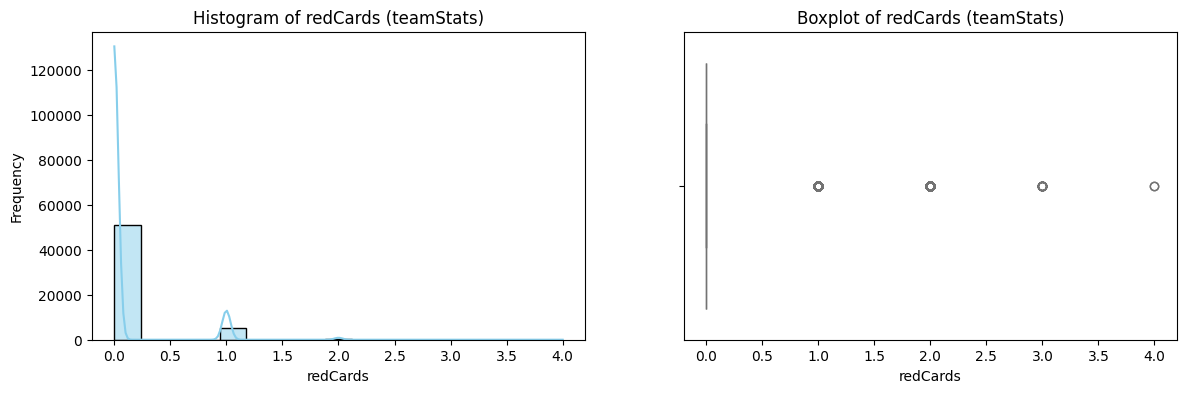

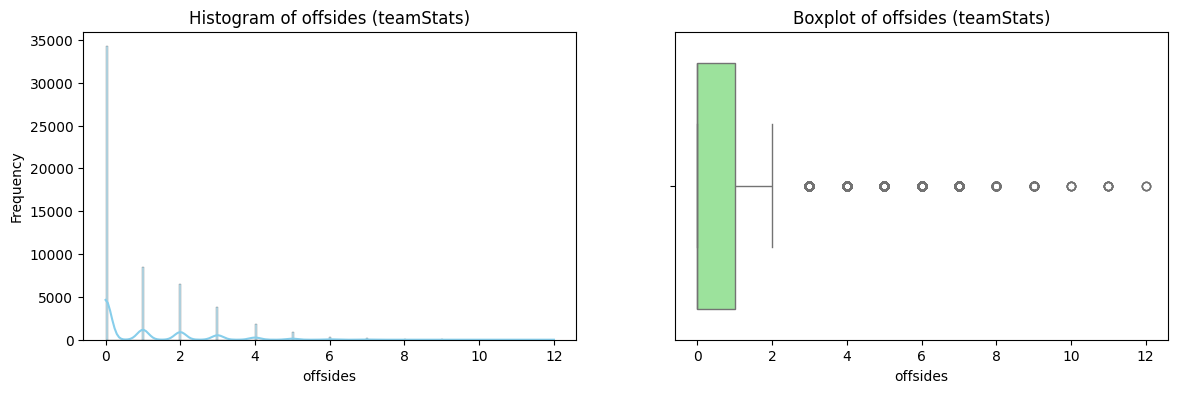

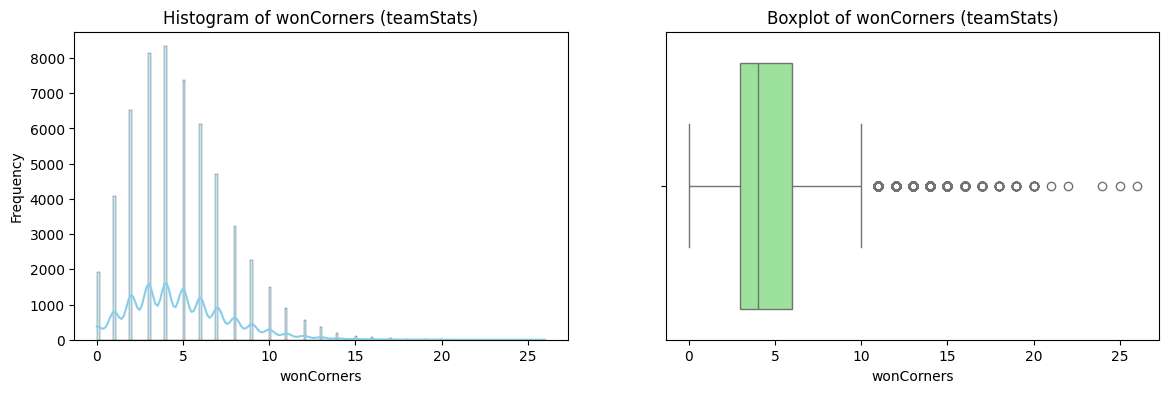

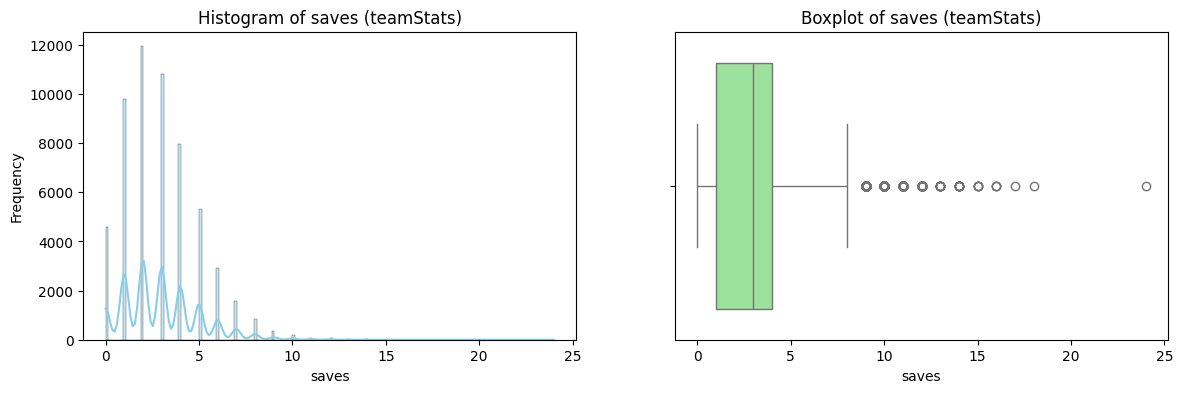

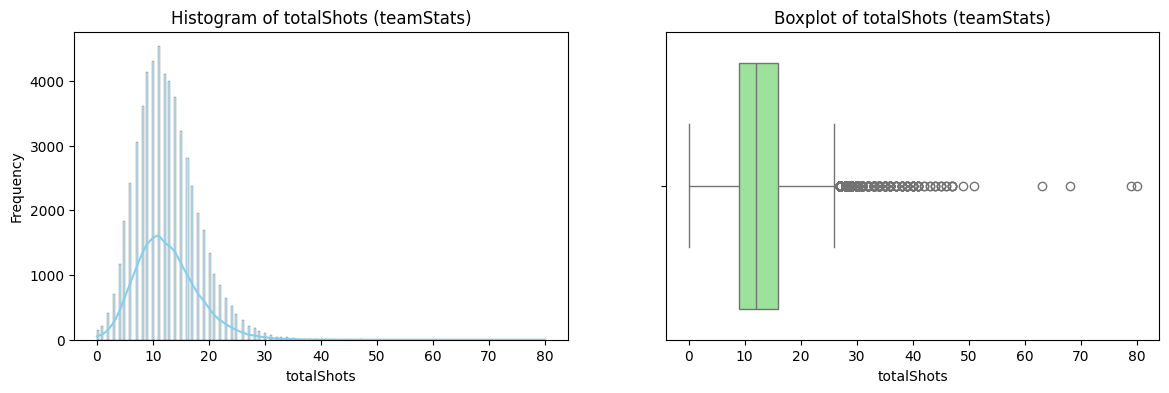

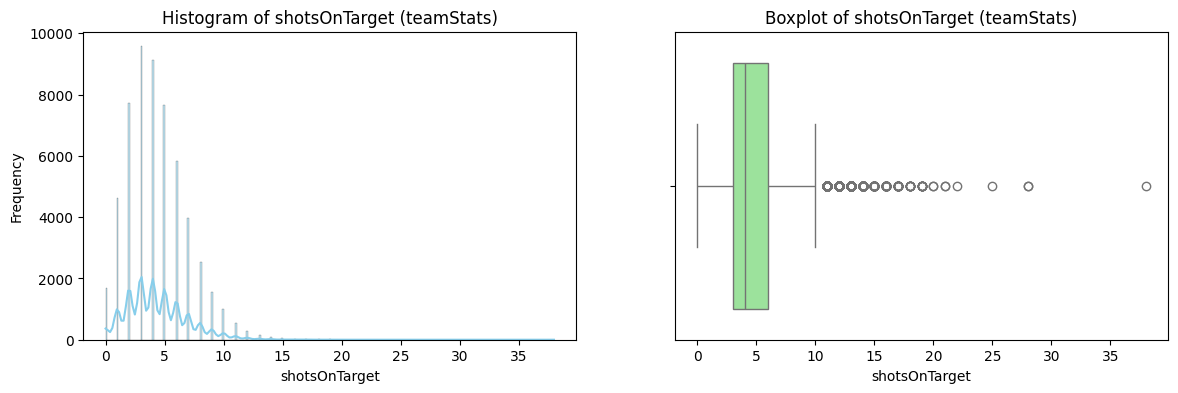

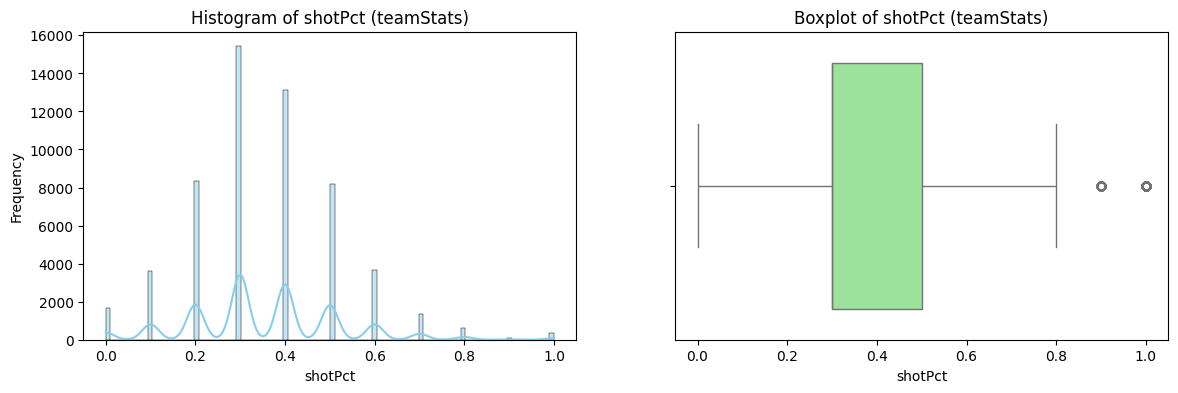

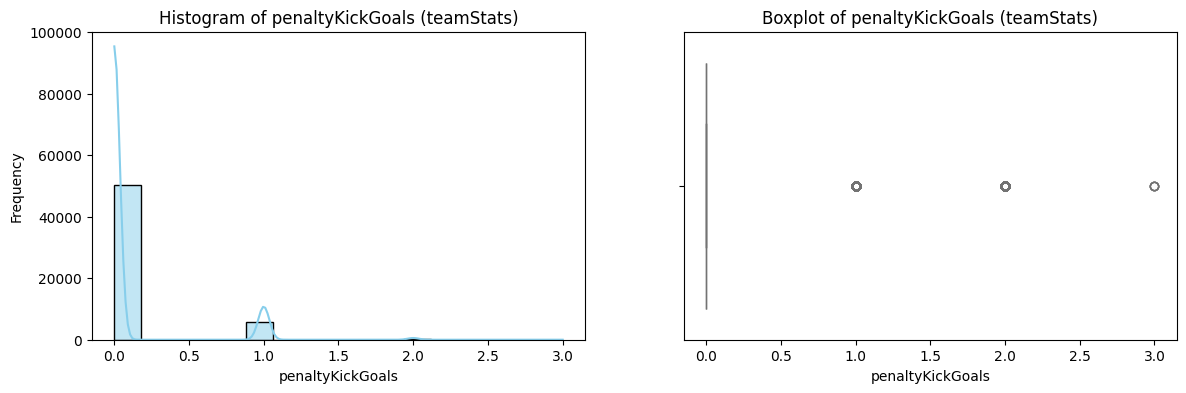

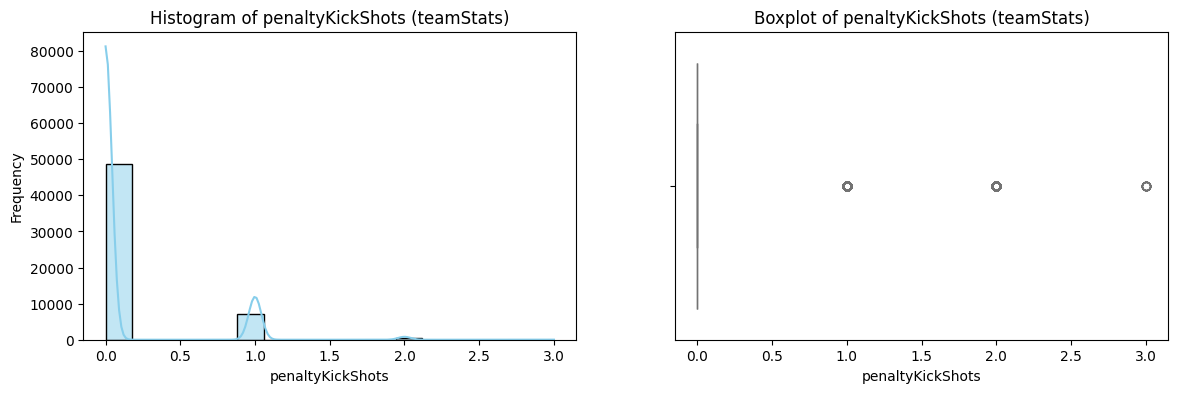

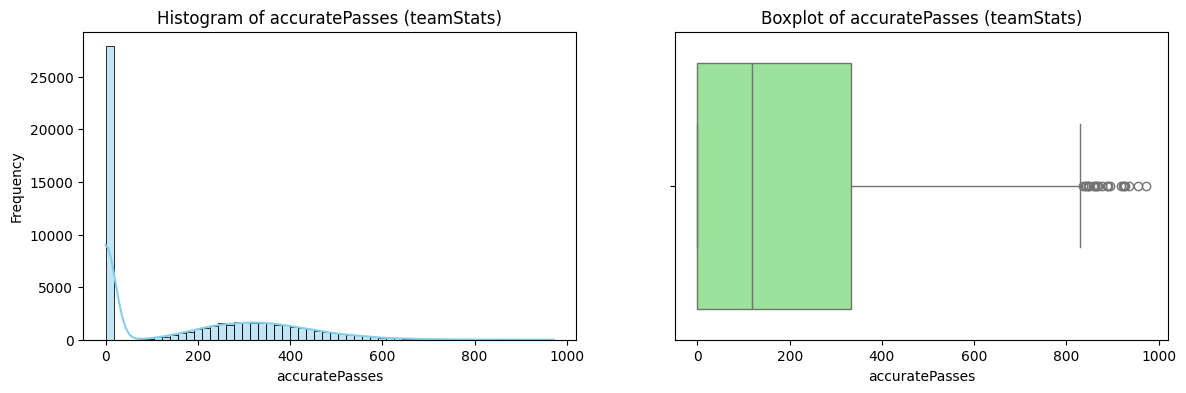

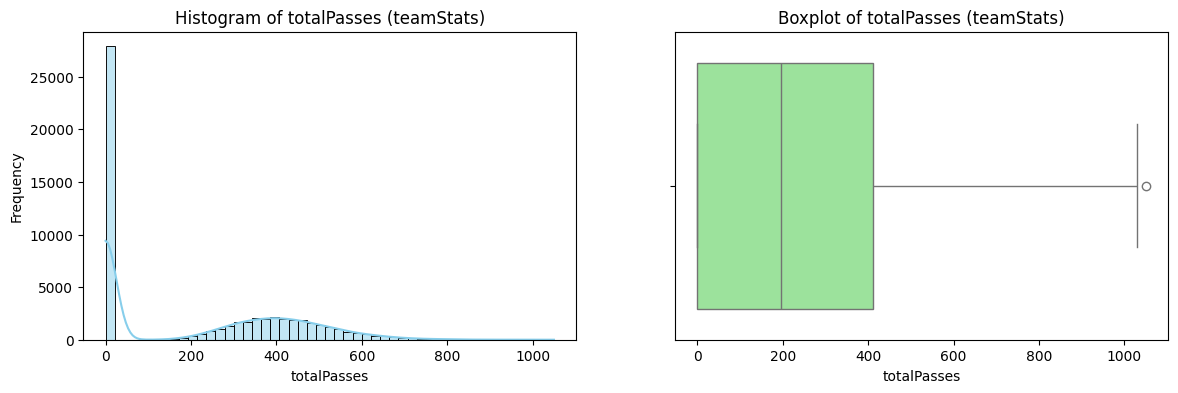

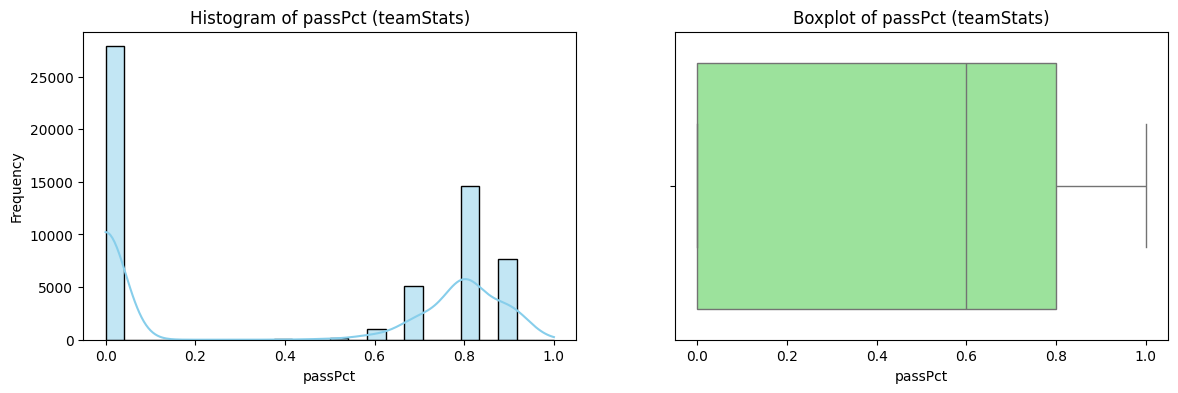

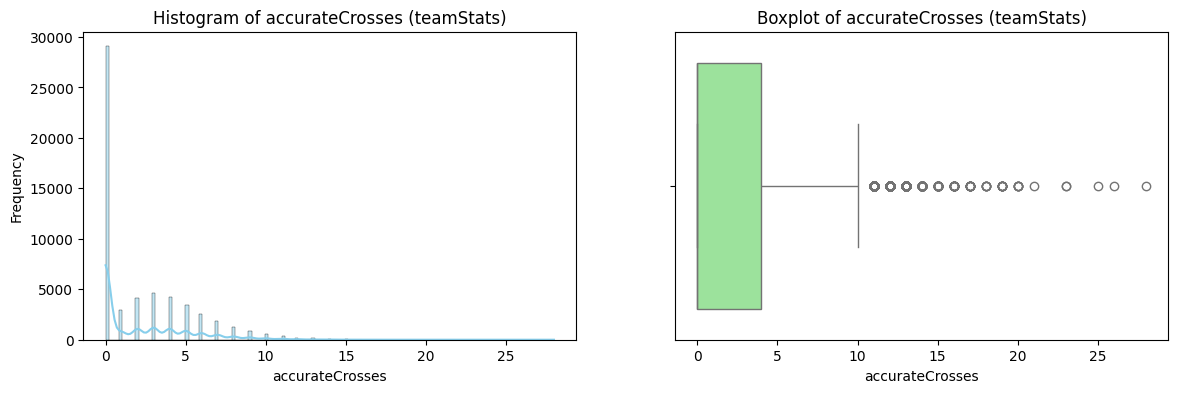

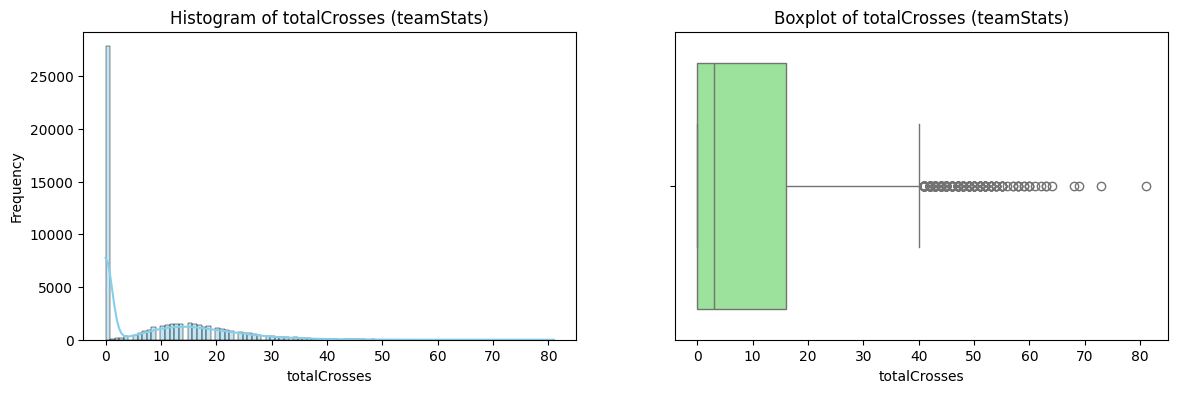

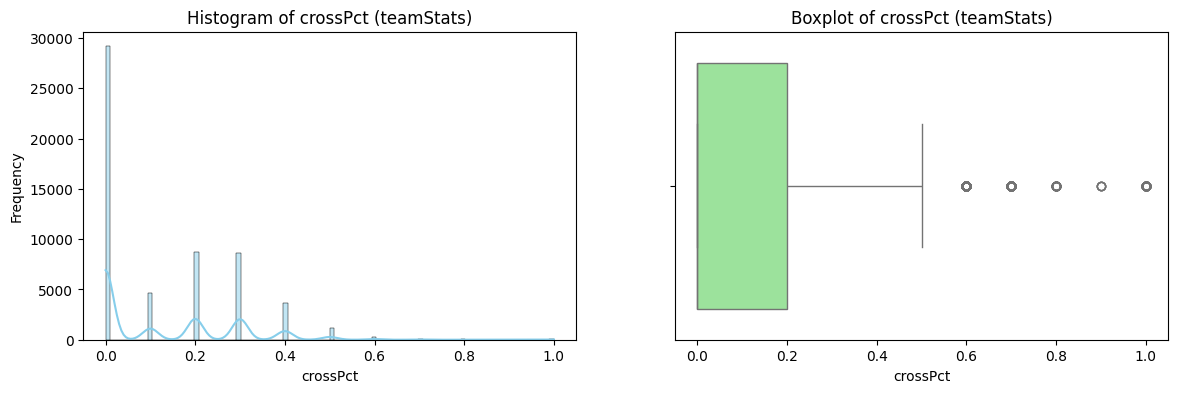

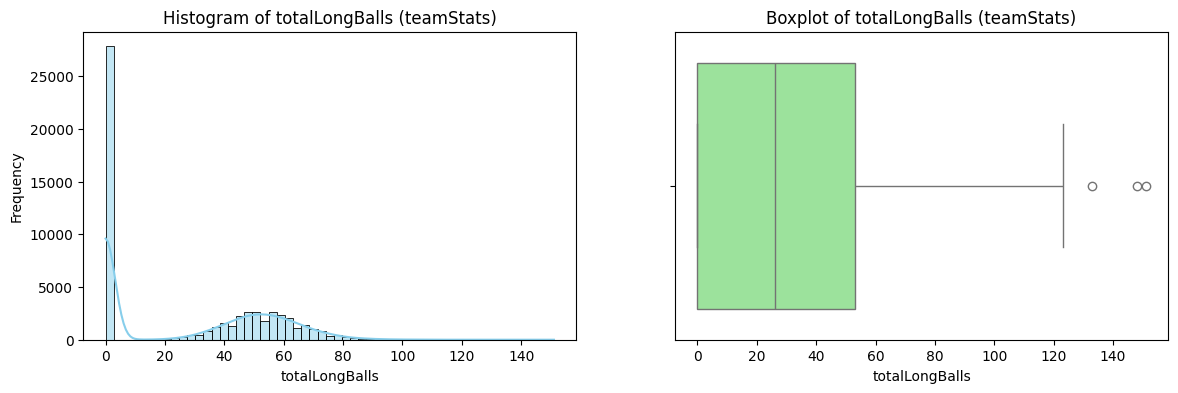

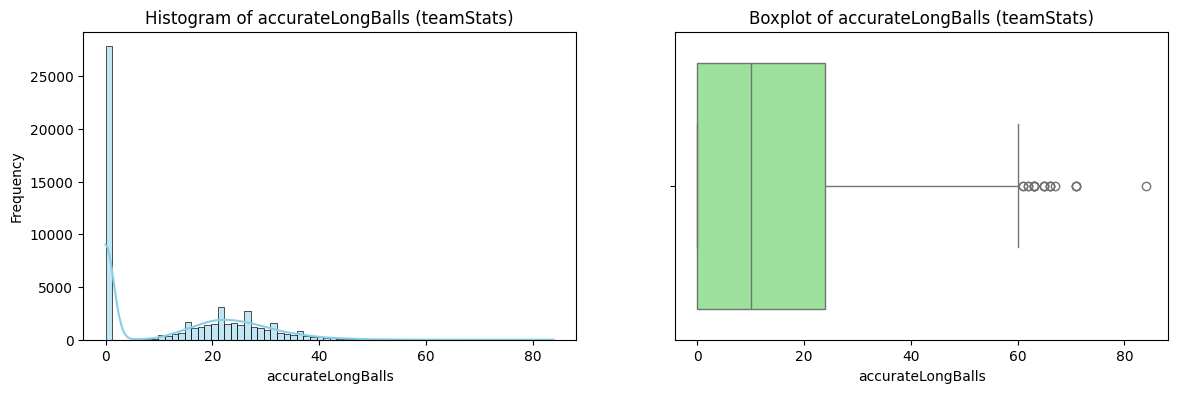

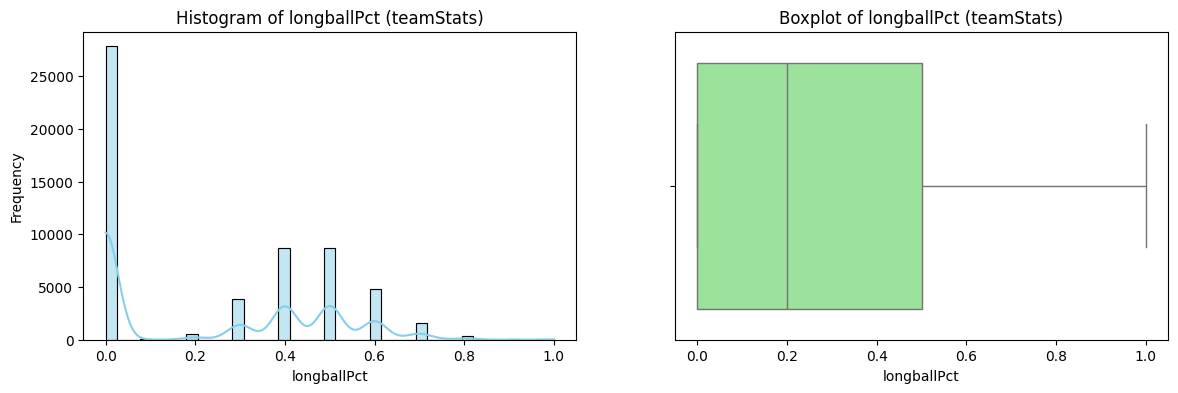

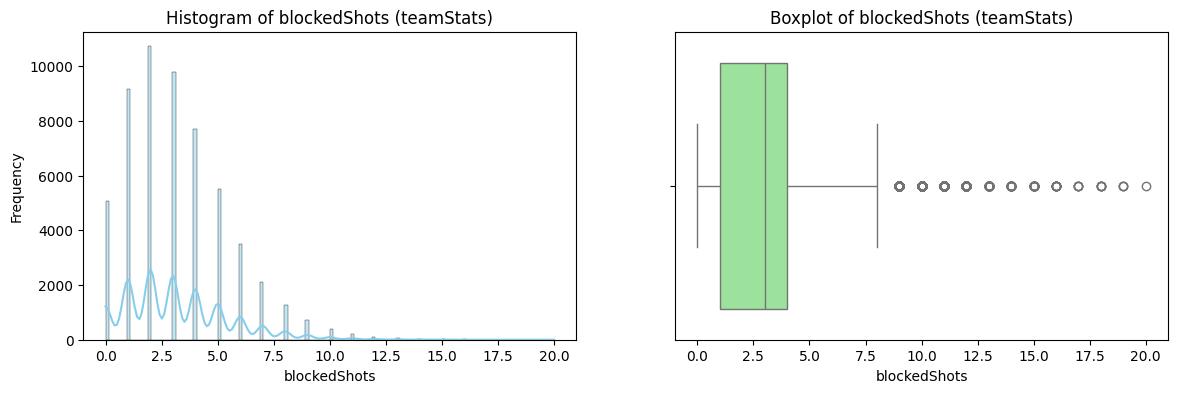

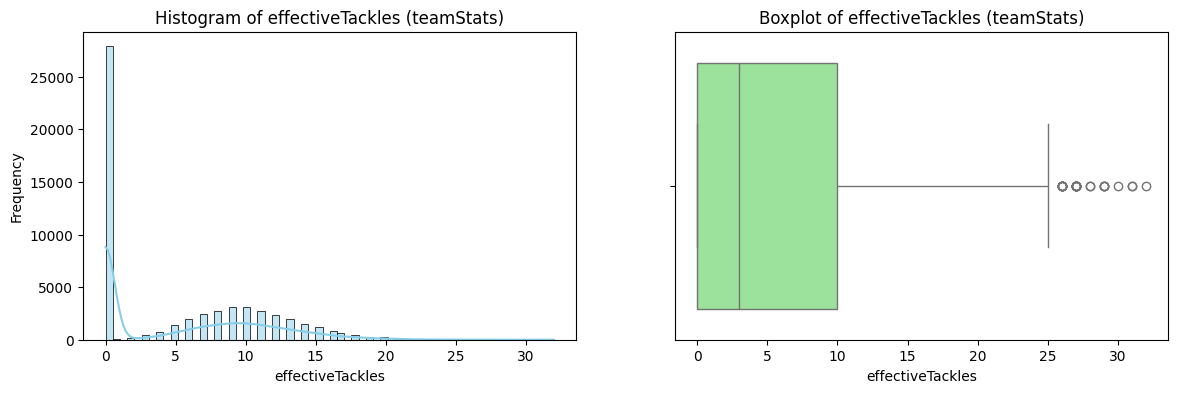

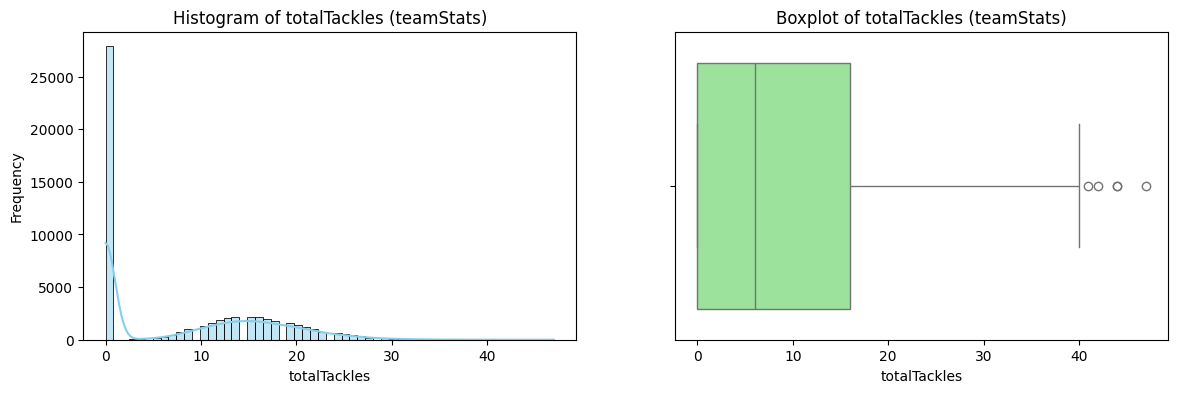

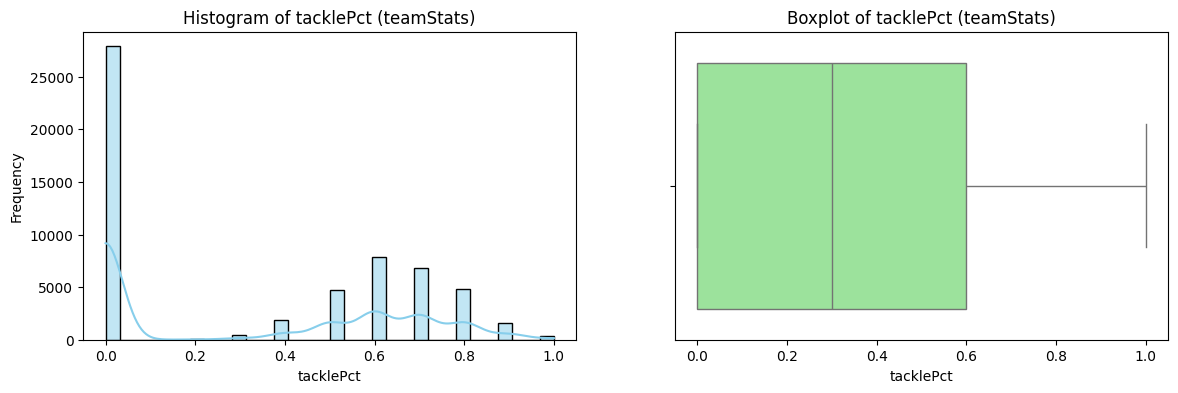

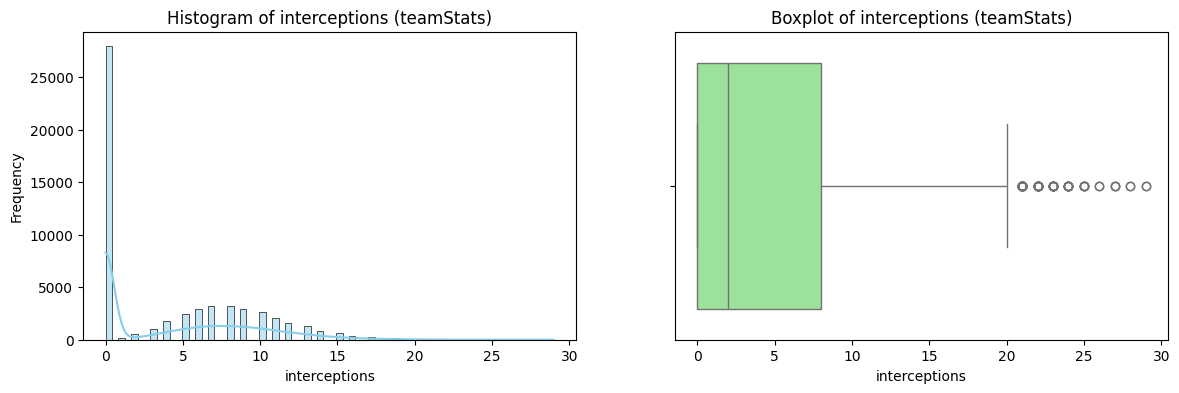

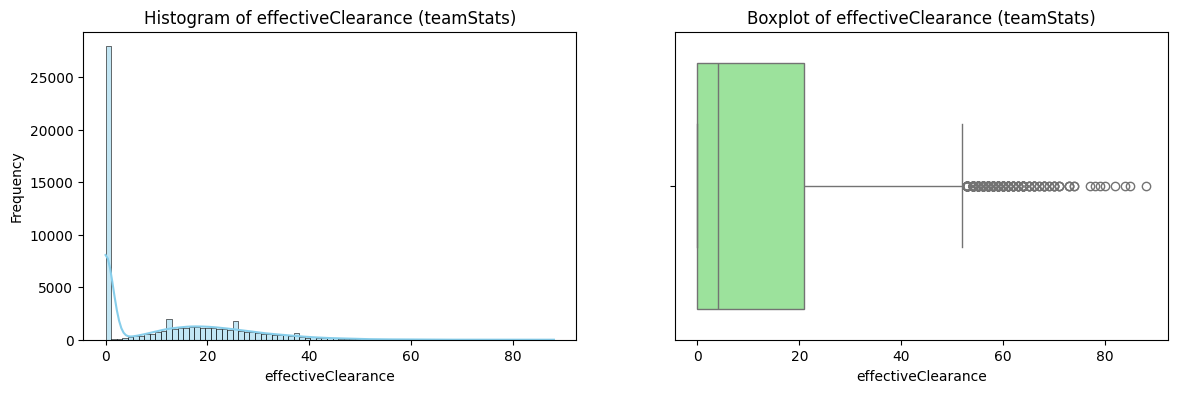

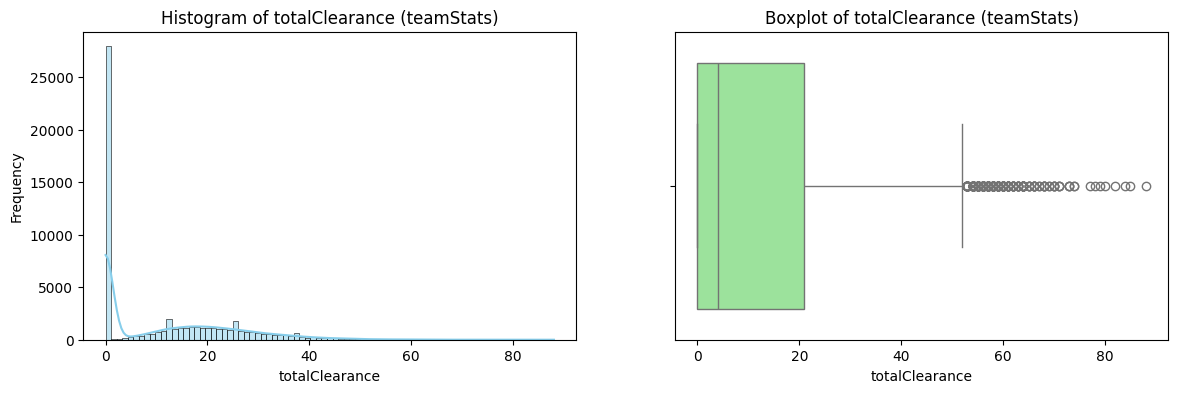

In [9]:
name="teamStats"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(teamStats, name)



### Distribution Analysis for standings ###

=== Descriptive Statistics for standings
         seasonType         year      leagueId     teamRank         teamId  \
count   6069.000000  6069.000000   6069.000000  6069.000000    6069.000000   
mean   13032.420992  2024.534190   6544.170374     6.763717   13748.569451   
std      425.897295     0.498871   5986.180923     5.940059   21428.742626   
min    12215.000000  2024.000000    620.000000     0.000000       2.000000   
25%    12654.000000  2024.000000   3903.000000     2.000000    2715.000000   
50%    13085.000000  2025.000000   4007.000000     5.000000    8416.000000   
75%    13347.000000  2025.000000   8312.000000    10.000000   20322.000000   
max    13812.000000  2025.000000  23633.000000    36.000000  131551.000000   

       gamesPlayed         wins         ties       losses       points  \
count  6069.000000  6069.000000  6069.000000  6069.000000  6069.000000   
mean     15.388038     5.810512     3.904762     5.672598    

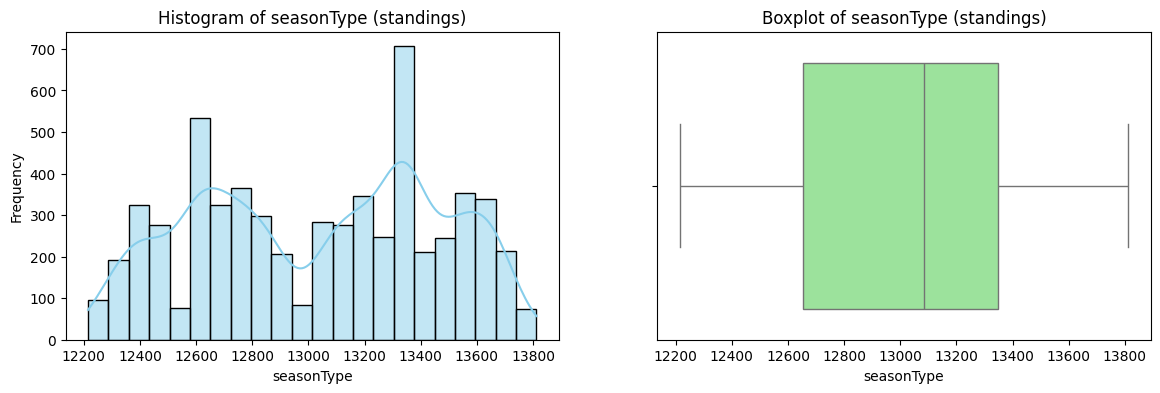

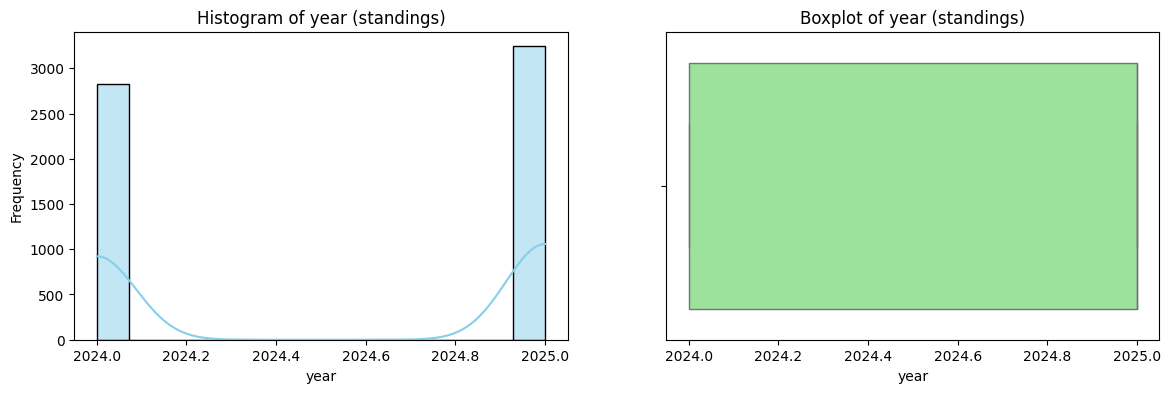

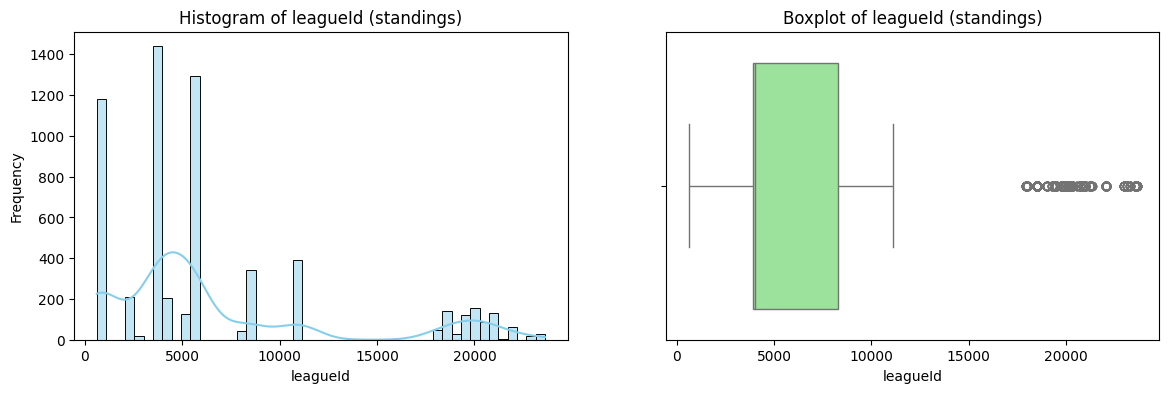

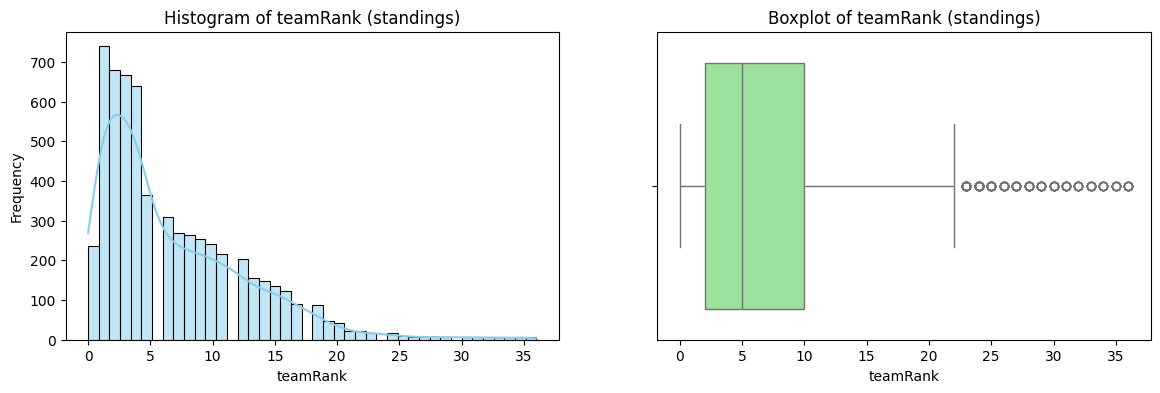

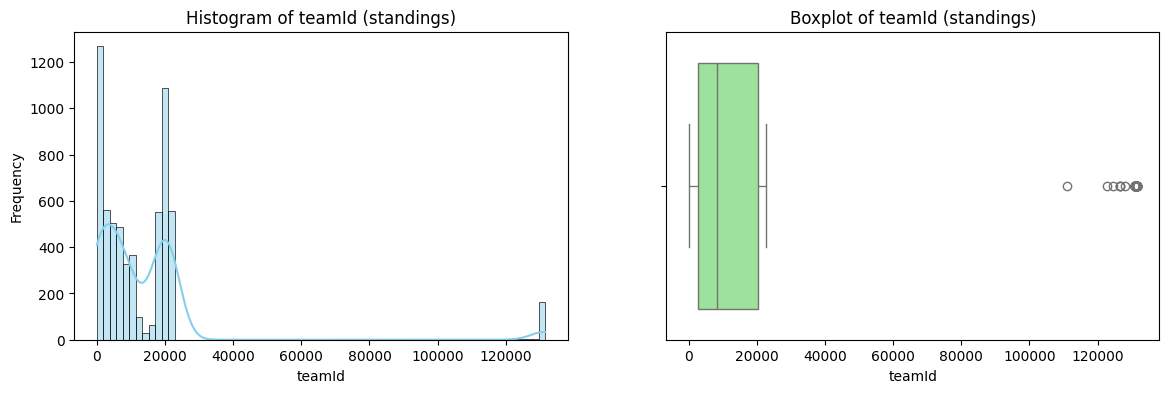

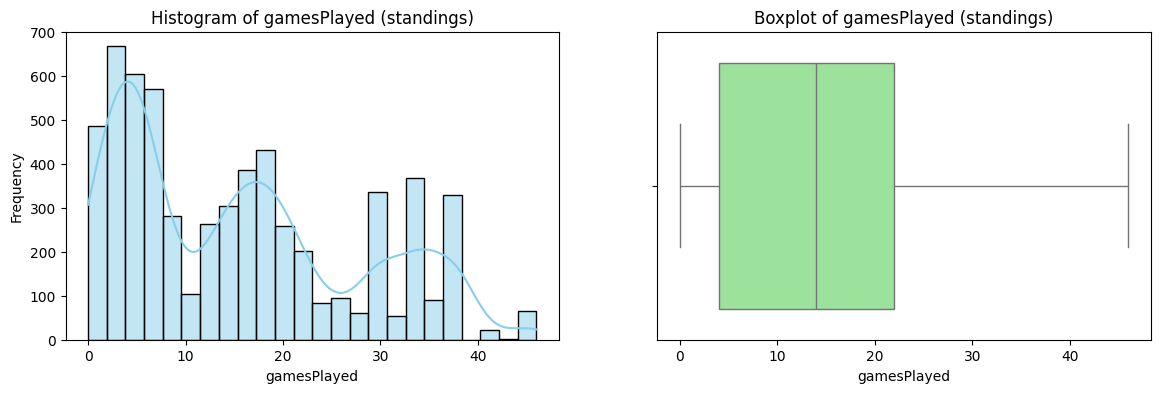

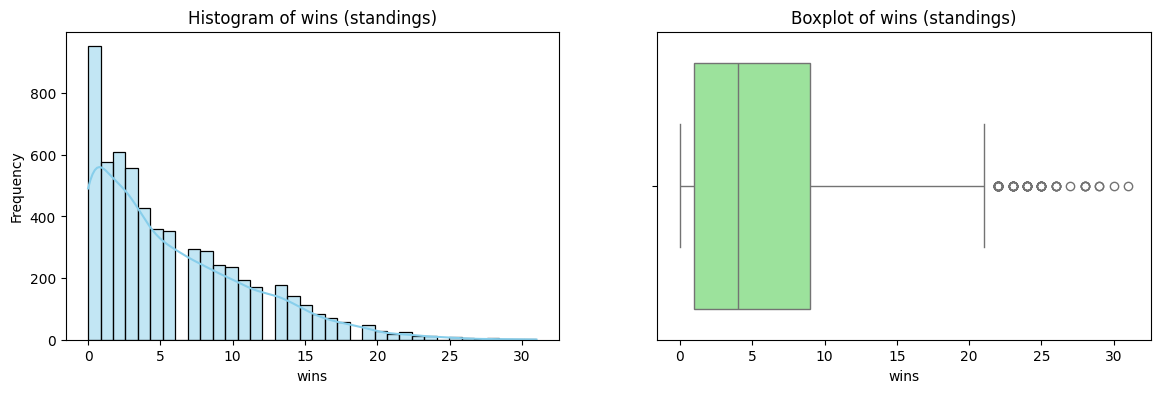

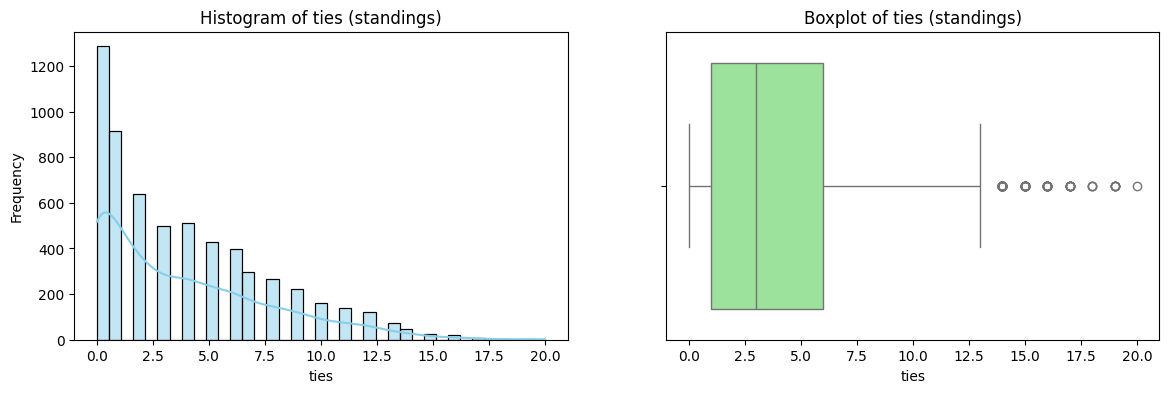

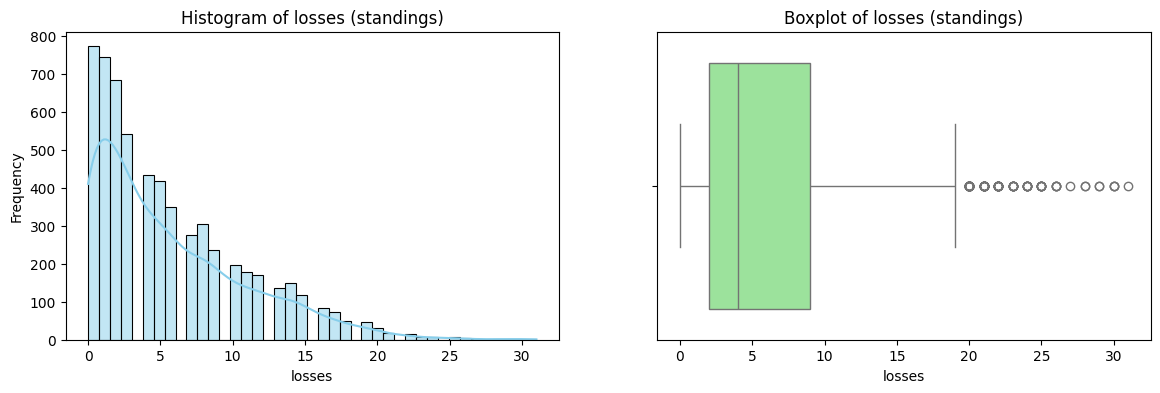

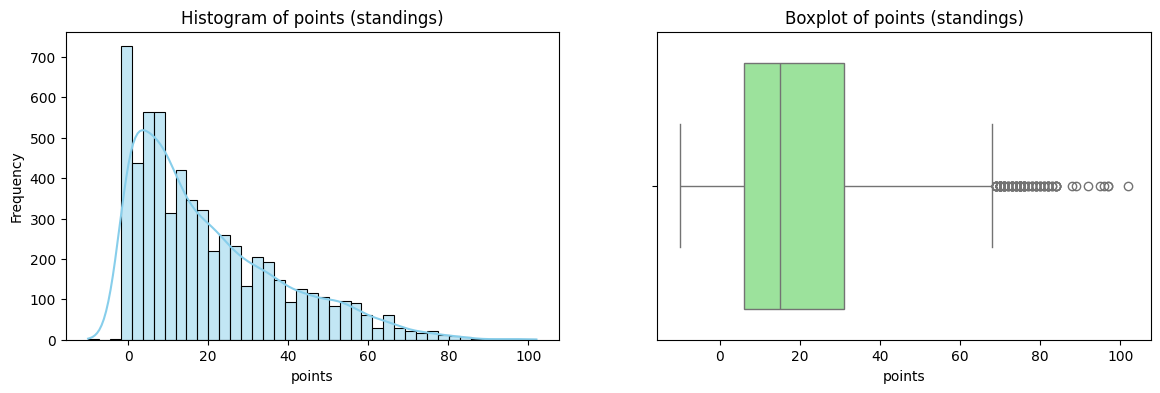

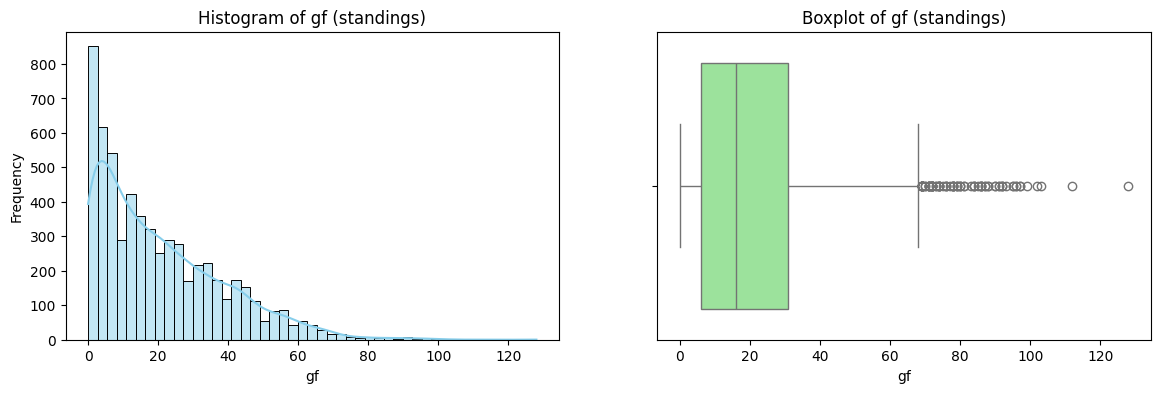

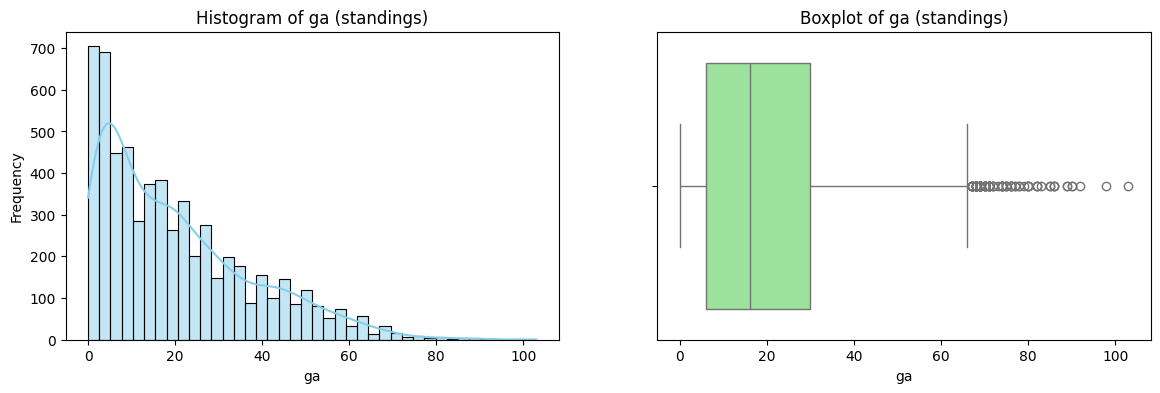

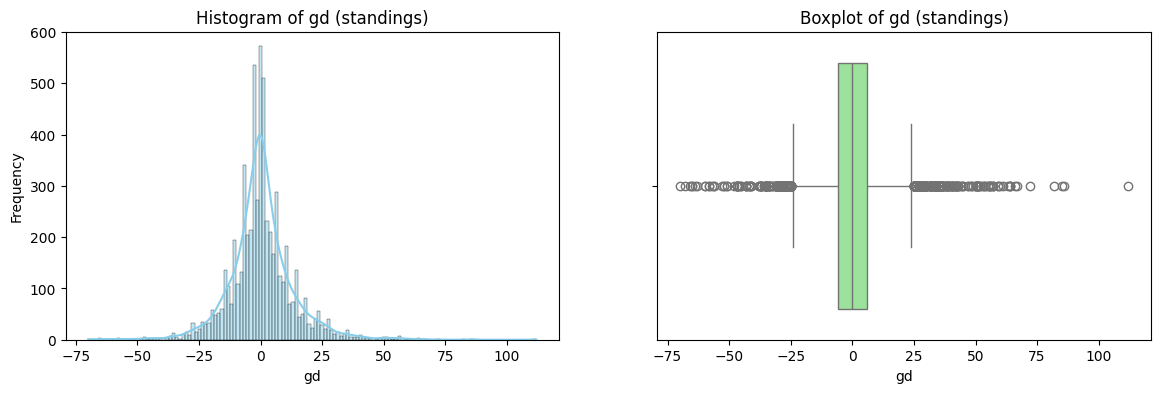

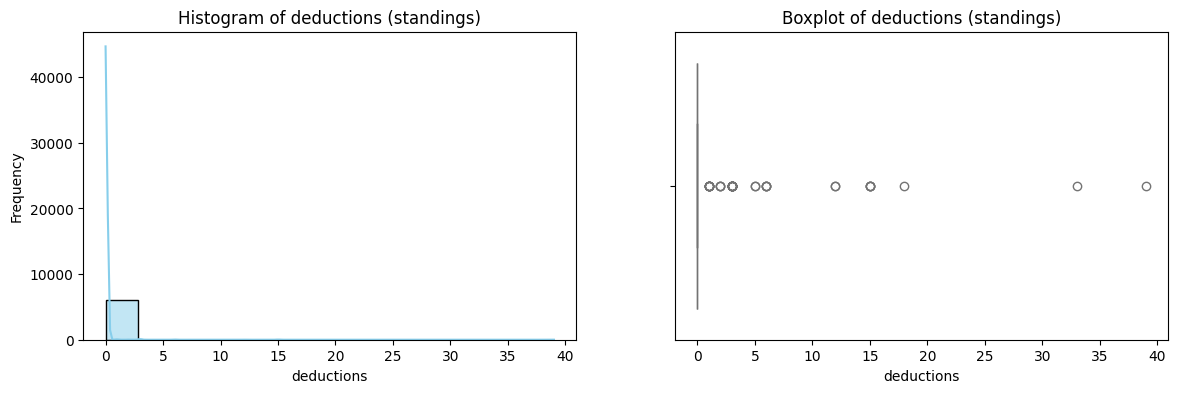

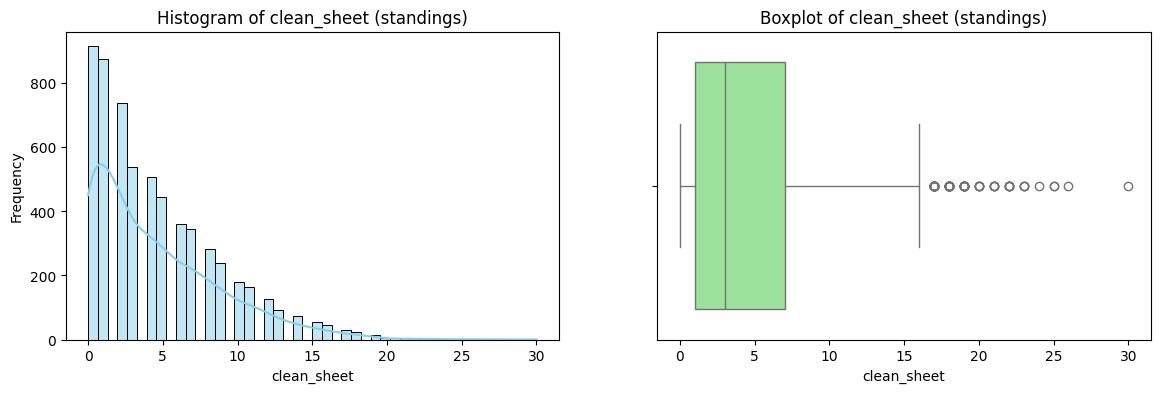

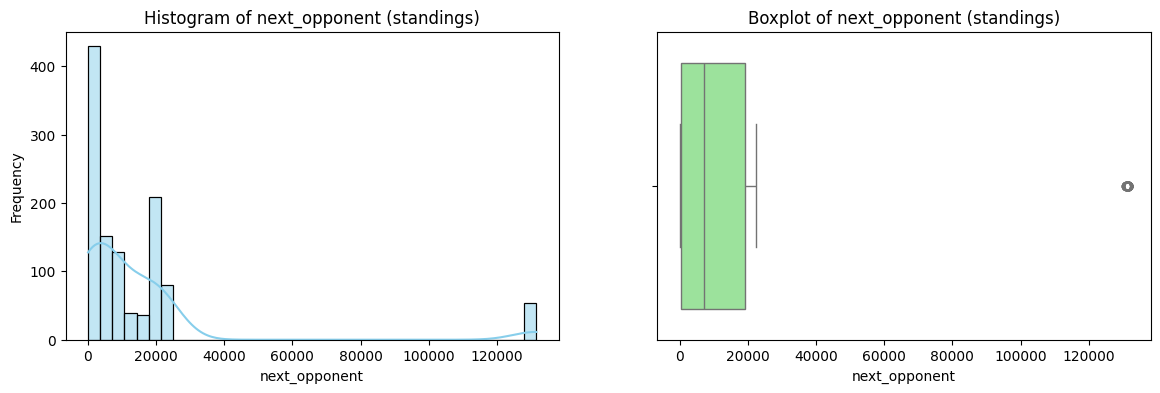

In [10]:
name="standings"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(standings, name)



### Distribution Analysis for leagues ###

=== Descriptive Statistics for leagues
         seasonType         year      leagueId
count   1084.000000  1084.000000   1084.000000
mean   12944.643911  2024.378229   8739.398524
std      419.958199     0.485169   7477.368015
min    12136.000000  2024.000000    620.000000
25%    12614.750000  2024.000000   3917.000000
50%    12925.500000  2024.000000   5337.000000
75%    13270.750000  2025.000000  17929.500000
max    13814.000000  2025.000000  23633.000000


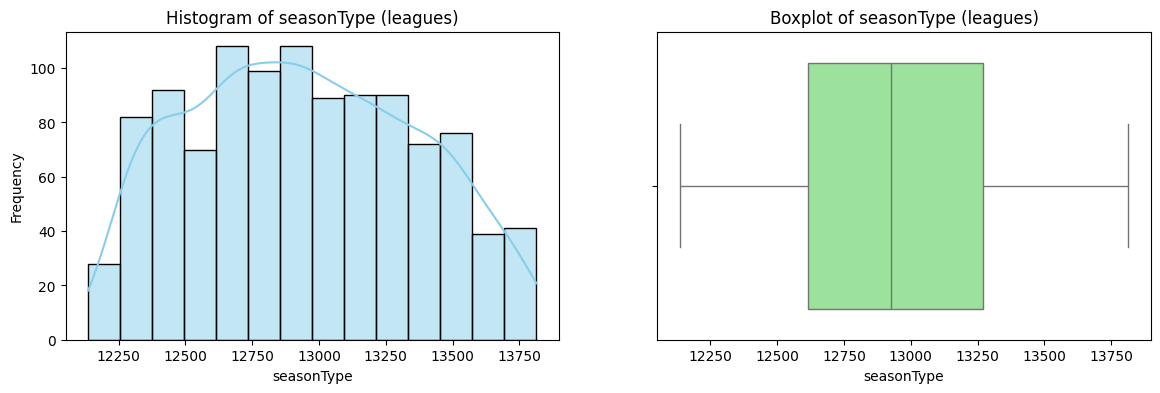

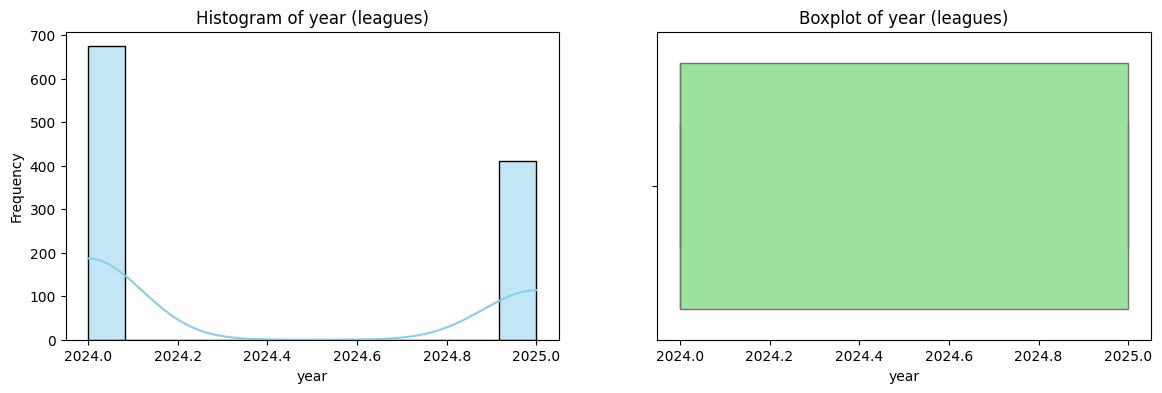

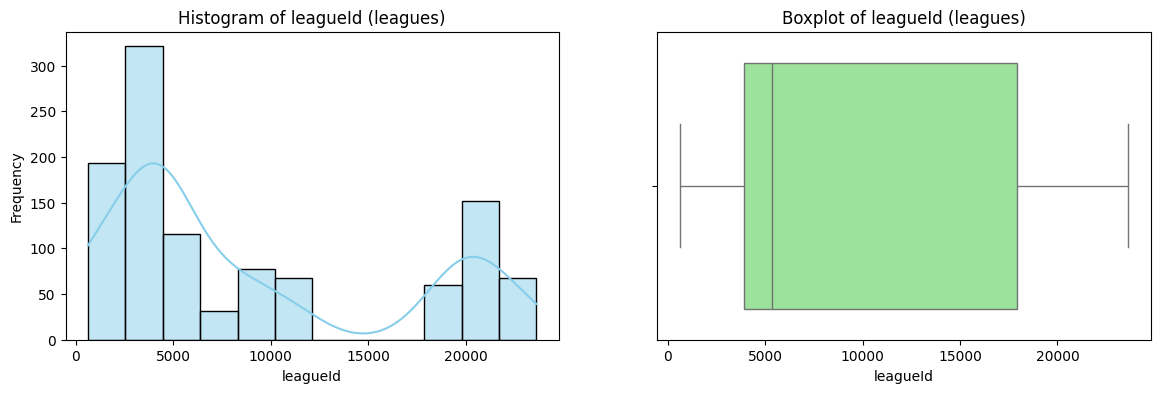

In [11]:
name="leagues"

print(f'\n\n### Distribution Analysis for {name} ###')
explore_distributions(leagues, name)

In [12]:
#checking for inconsistencies in STANDINGS

#Display the columns in the standings DF
print('List of columns in standings: ', standings.columns.to_list())

#Identify and count teams that have played no matches
teams_zero_games=standings[standings['gamesPlayed']==0]
print("No. of teams with 0 matches played: ",teams_zero_games.shape[0])
if not teams_zero_games.empty:
    #Show a preview of affected teams
    print(teams_zero_games[['teamId','gamesPlayed','points']].head())

#Identify and count teams with 0 pts
teams_zero_points=standings[standings['points']==0]
print("\nNumber of Team with 0 pts: ",teams_zero_points.shape[0])
if not teams_zero_points.empty:
    #Show a preview of the affected teams
    print(teams_zero_points[['teamId','gamesPlayed','points']].head())
    

List of columns in standings:  ['seasonType', 'year', 'leagueId', 'last_matchDateTime', 'teamRank', 'teamId', 'gamesPlayed', 'wins', 'ties', 'losses', 'points', 'gf', 'ga', 'gd', 'deductions', 'clean_sheet', 'form', 'next_opponent', 'next_homeAway', 'next_matchDateTime', 'timeStamp']
No. of teams with 0 matches played:  341
    teamId  gamesPlayed  points
24     164            0       0
25     481            0       0
26     465            0       0
27     459            0       0
28     472            0       0

Number of Team with 0 pts:  726
    teamId  gamesPlayed  points
22   10265            2       0
23   15502            2       0
24     164            0       0
25     481            0       0
26     465            0       0


In [14]:
initial_count = len(standings)
print("Initial number of rows in standings:", initial_count)

#Mask to identify rows with 0 matches or 0 pts
mask_zero=(standings['gamesPlayed']==0) | (standings['points']==0) # the | is used and not the or operator bcz inside Pandas/NumPy, you must use the | symbol because you are comparing entire lists (Series) of data at once, not just single values.

#select and display the rows to be removed
rows_to_remove=standings[mask_zero]
print(f' No. of rows to remove (0 matches or 0 points): {len(rows_to_remove)}')
print(rows_to_remove[['teamId','gamesPlayed','points']].head())

#Create a new df w/o the unwanted rows
standings_cleaned=standings[~mask_zero] #~ means not operator

#Display the no. of rows after removal and the no. of removed rows
final_count= len(standings_cleaned)
print('No. of rows after removal: ', final_count)
print(f'Rows removed: {initial_count - final_count}')

Initial number of rows in standings: 6069
 No. of rows to remove (0 matches or 0 points): 726
    teamId  gamesPlayed  points
22   10265            2       0
23   15502            2       0
24     164            0       0
25     481            0       0
26     465            0       0
No. of rows after removal:  5343
Rows removed: 726


In [16]:
#CHECKING INCONSITENCIES IN TEAMSTATS

#Display the collumns in teamStats
print('Collumns in teamStats',teamStats.columns.to_list())

#Check if possessionPct collumn for values outside the range [0,100]
if 'possestionPct' in teamStats.columns:
    out_of_range_pos=teamStats[
        (teamStats['possessionPct']<0) | (teamStats['possessionPct']>100)
    ]
    if not out_of_range_pos.empty:
        print(f'\n Anomaly: possessionPct outside [0,100] (count={len(out_of_range_pos)})')
        display(out_of_range_pos[['teamId','possessionPct']].head())
    else: 
        print('No Anomalies for possessionPCT')

#Check columns woth percentage values in decimal form
decimal_pct_cols=['shotPct','passPct','crossPct','longballPct']
for col in decimal_pct_cols:
    if col in teamStats.columns:
        out_of_range_decimal=teamStats[
            (teamStats[col]<0) | (teamStats[col]>1)
        ]
        if not out_of_range_decimal.empty:
            print(f'\n Anomaly: {col} outside [0,1] (count={len(out_of_range_decimal)})')
            display(out_of_range_decimal[['teamId',col]].head())

        else: 
            print(f'No anomalies for {col}')

Collumns in teamStats ['seasonType', 'eventId', 'teamId', 'teamOrder', 'possessionPct', 'foulsCommitted', 'yellowCards', 'redCards', 'offsides', 'wonCorners', 'saves', 'totalShots', 'shotsOnTarget', 'shotPct', 'penaltyKickGoals', 'penaltyKickShots', 'accuratePasses', 'totalPasses', 'passPct', 'accurateCrosses', 'totalCrosses', 'crossPct', 'totalLongBalls', 'accurateLongBalls', 'longballPct', 'blockedShots', 'effectiveTackles', 'totalTackles', 'tacklePct', 'interceptions', 'effectiveClearance', 'totalClearance', 'updateTime']
No anomalies for shotPct
No anomalies for passPct
No anomalies for crossPct
No anomalies for longballPct


In [19]:
#List of collumns to check for negative values
count_columns = [
    "foulsCommitted", "yellowCards", "redCards", "offsides", "wonCorners",
    "saves", "totalShots", "shotsOnTarget", "penaltyKickGoals", "penaltyKickShots",
    "accuratePasses", "totalPasses", "accurateCrosses", "totalCrosses",
    "totalLongBalls", "accurateLongBalls", "blockedShots",
    "effectiveTackles", "totalTackles", "interceptions",
    "effectiveClearance", "totalClearance"
]

#For ech columns, check for negaive vals
for col in count_columns:
    if col in teamStats.columns:
        neg_vals=teamStats[teamStats[col]<0]
        if not neg_vals.empty:
            print(f'\n Anomaly: {col} should not be negative (count={len(neg_vals)})')
            display(neg_vals[['teamId',col]].head())

        else:
            print(f' No anomalies for {col} (no neg values)')

 No anomalies for foulsCommitted (no neg values)
 No anomalies for yellowCards (no neg values)
 No anomalies for redCards (no neg values)
 No anomalies for offsides (no neg values)
 No anomalies for wonCorners (no neg values)
 No anomalies for saves (no neg values)
 No anomalies for totalShots (no neg values)
 No anomalies for shotsOnTarget (no neg values)
 No anomalies for penaltyKickGoals (no neg values)
 No anomalies for penaltyKickShots (no neg values)
 No anomalies for accuratePasses (no neg values)
 No anomalies for totalPasses (no neg values)
 No anomalies for accurateCrosses (no neg values)
 No anomalies for totalCrosses (no neg values)
 No anomalies for totalLongBalls (no neg values)
 No anomalies for accurateLongBalls (no neg values)
 No anomalies for blockedShots (no neg values)
 No anomalies for effectiveTackles (no neg values)
 No anomalies for totalTackles (no neg values)
 No anomalies for interceptions (no neg values)
 No anomalies for effectiveClearance (no neg values)


In [21]:
#CHeck that each subcomponent does not exceed its total

checks_subcomponents=[
    ('shotsOnTarget', "totalShots"),
    ('penaltyKickGoals','penaltyKickShots'),
    ('accuratePasses', 'totalPasses'),
    ('accurateCrosses','totalCrosses'),
    ('accurateLongBalls', 'totalLongBalls'),
]

for subcol, totcol in checks_subcomponents:
    if subcol in teamStats.columns and totcol in teamStats.columns:
        #Identify cases where the subcomponent is greater than the total 
        subcomp_issue=teamStats[teamStats[subcol]>teamStats[totcol]]
        if not subcomp_issue.empty:
            print(f"\n Anomaly: {subcol}>{totcol} (count={len(subcomp_issue)})")
            display(subcomp_issue[['teamId',subcol,totcol]].head())
        else:
            print(f" No anomalies for {subcol} vs {totcol}")
            

 No anomalies for shotsOnTarget vs totalShots
 No anomalies for penaltyKickGoals vs penaltyKickShots
 No anomalies for accuratePasses vs totalPasses
 No anomalies for accurateCrosses vs totalCrosses
 No anomalies for accurateLongBalls vs totalLongBalls


In [ ]:
#Consistency test for ratios

ratio_checks=[
    ("shotPct",'shotsOnTarget','totalShots'),
    ('passPct','accuratePasses','totalPasses'),
    ('crossPct', 'accurateCrosses','totalCrosses'),
    ('longballPct','accurateLongBalls','totalLongBalls')

]

tolerance=0.1 #acceptable margin or error

for ratio_col, sub_col, tot_col in ratio_checks:
    if all(c in teamStats.columns for c in [ratio_col, sub_col,tot_col]):
        mask=(teamStats[tot_col]>0) #avoid div by 0
        #calculate discrepancy btw the displayed ration and the computed ration
        ratio_issue=teamStats[mask & ((teamStats[ratio_col]-(teamStats[sub_col]/teamStats[tot_col])).abs()>tolerance)]

        if not ratio_issue.empty:
            print(f"\n Anomaly: {ratio_col} inconsistent with {sub_col}/{tot_col} (count={len(ratio_issue)})")
            display(ratio_issue[[ratio_col,sub_col,tot_col,"teamId"]].head())

        else:
            print(f' No Anomalies for {ratio_col} (ratio {sub_col}/{tot_col}) within tolerance margin')

print('\n=== CHECKS COMPLETED ===')# 

 No Anomalies for shotPct (ratio shotsOnTarget/totalShots) within tolerance margin
 No Anomalies for passPct (ratio accuratePasses/totalPasses) within tolerance margin
 No Anomalies for crossPct (ratio accurateCrosses/totalCrosses) within tolerance margin
 No Anomalies for longballPct (ratio accurateLongBalls/totalLongBalls) within tolerance margin

=== CHECKS COMPLETED ===
